In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

from sklearn.metrics import accuracy_score 
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report

from src.visualization import feature_importances_plot

# warnings -> to silence warnings
import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42
N_JOBS = -1
class_names = ["Canis","Dysg. Equisimilis", "Dysg. Dysgalactiae"]

/opt/conda/lib/python3.10/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
df = pd.read_csv("data/Dati_Matemaldomics_46pic.csv", delimiter=';', index_col='ID Strain')
maldi = df[df.columns[9:55]]

**Preparazione dati**

In [3]:
maldi.fillna(0,inplace=True)
maldi = maldi.replace(',', '.', regex=True)
columns = maldi.columns
for column in columns:
    maldi[column] = maldi[column].astype(float)
maldi

,2223.14096740459,2241.07398894549,2262.75751034224,2679.80285558542,2978.2964083814,3159.4412370969,3354.28405017382,3364.60847172059,3397.90986107287,3418.17496544302,...,9030.35184440851,9073.20815866341,9487.18319483418,10103.2028390456,10400.8057644159,10491.1665411138,10930.5483306152,13276.7324948084,14943.0383506345,15048.8944894299
ID Strain,,,,,,,,,,,,,,,,,,,,,
V13,0.000665,0.000180,0.000198,0.000059,0.000865,0.000497,0.000197,0.000272,0.000578,0.000198,...,0.000206,0.000133,0.000587,0.000180,0.000065,0.000065,0.000172,0.000076,0.000058,0.000142
V142,0.000648,0.000156,0.000192,0.000400,0.000698,0.000414,0.000684,0.000349,0.000617,0.000494,...,0.000219,0.000205,0.000465,0.000193,0.000142,0.000116,0.000165,0.000067,0.000067,0.000194
V151,0.000545,0.000331,0.000204,0.000277,0.000613,0.000464,0.000279,0.001031,0.000624,0.000409,...,0.000261,0.000263,0.000585,0.000235,0.000198,0.000152,0.000208,0.000084,0.000092,0.000069
V160,0.000509,0.000191,0.000193,0.000266,0.000489,0.000358,0.000628,0.000692,0.000564,0.000611,...,0.000311,0.000312,0.000083,0.000241,0.000242,0.000187,0.000245,0.000082,0.000075,0.000136
V161,0.000517,0.000118,0.000158,0.000163,0.000610,0.000502,0.000621,0.000315,0.000507,0.000638,...,0.000206,0.000224,0.000711,0.000242,0.000156,0.000116,0.000154,0.000093,0.000072,0.000203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V800,0.000456,0.000253,0.000125,0.000061,0.000586,0.000365,0.000258,0.001095,0.000537,0.000214,...,0.000102,0.000195,0.000843,0.000250,0.000088,0.000109,0.000298,0.000060,0.000073,0.000059
V82,0.000459,0.000121,0.000147,0.000270,0.000571,0.000338,0.000596,0.000321,0.000537,0.000668,...,0.000263,0.000277,0.000452,0.000254,0.000211,0.000162,0.000203,0.000059,0.000070,0.000144
V90,0.000505,0.000154,0.000158,0.000181,0.000610,0.000473,0.000374,0.000525,0.000513,0.000377,...,0.000288,0.000310,0.000671,0.000237,0.000224,0.000185,0.000230,0.000089,0.000080,0.000137


In [4]:
map_target = {
    "Streptococcus canis" : 0,
    "Streptococcus dysgalactiae subsp. equisimilis" : 1,
    "Streptococcus dysgalactiae subsp. dysgalactiae" : 2  
}

map_target_inv = {
    0 : "Strept. canis",
    1 : "Strept. dysg. equisimilis",
    2 : "Strept. dysg. dysgalactiae" 
}
df['target'] = df["Putative Subspecies"].map(map_target)

## Modello con tutte le colonne maldi

In [5]:
y = df['target']
X = maldi

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [7]:
print(X_train.shape)
print(X_test.shape)

(123, 46)
(31, 46)


#Scaling dati
ss = StandardScaler()

X_train = ss.fit_transform(X=X_train)
X_test = ss.transform(X=X_test)

In [8]:
#Scaling dati
mm = MinMaxScaler()

X_train = mm.fit_transform(X=X_train)
X_test = mm.transform(X=X_test)

#### Logistic regression with all maldi

In [9]:
logr = LogisticRegression()
logr.fit(X=X_train,y=y_train)

LogisticRegression()

#### Cross Validation

In [10]:
skfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
logr_cv_scores = cross_val_score(estimator=logr, X=X_train, y=y_train, 
                                 scoring="accuracy", cv=skfold, n_jobs=N_JOBS, verbose=1)
print(f"Mean CV accuracy: {logr_cv_scores.mean():.4f} +/- {logr_cv_scores.std():.4f}")
logr_cv_scores

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


Mean CV accuracy: 0.9519 +/- 0.0523


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.3s finished


array([1.        , 0.92307692, 0.84615385, 1.        , 1.        ,
       0.91666667, 0.91666667, 1.        , 0.91666667, 1.        ])

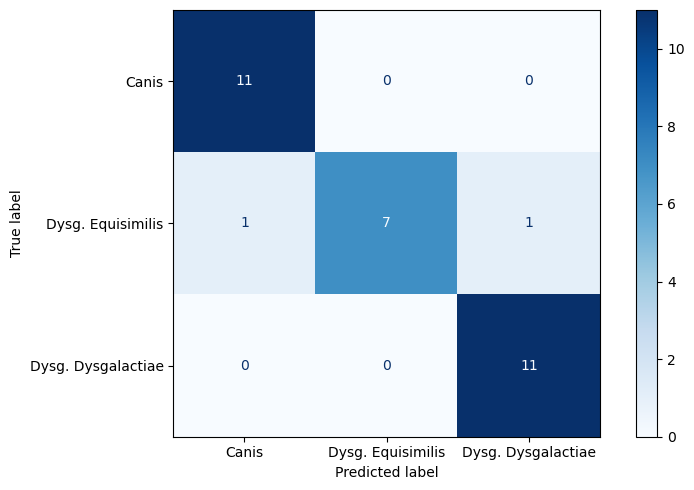

In [11]:
fig, ax = plt.subplots(figsize=(8, 5))
plot_confusion_matrix(estimator=logr, X=X_test, y_true=y_test, cmap='Blues', display_labels=class_names, ax=ax)
plt.tight_layout()
plt.show()

In [12]:
y_pred = logr.predict(X_test)
accuracy_logic = logr.score(X_test, y_test)
report = classification_report(y_true=y_test, y_pred=y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        11
           1       1.00      0.78      0.88         9
           2       0.92      1.00      0.96        11

    accuracy                           0.94        31
   macro avg       0.94      0.93      0.93        31
weighted avg       0.94      0.94      0.93        31



#### Decision tree with all maldi

In [13]:
dtc = DecisionTreeClassifier(random_state=RANDOM_STATE)
dtc = dtc.fit(X=X_train, y=y_train)
dtc

DecisionTreeClassifier(random_state=42)

In [14]:
print(f"Profonfità albero: {dtc.get_depth()}")

Profonfità albero: 4


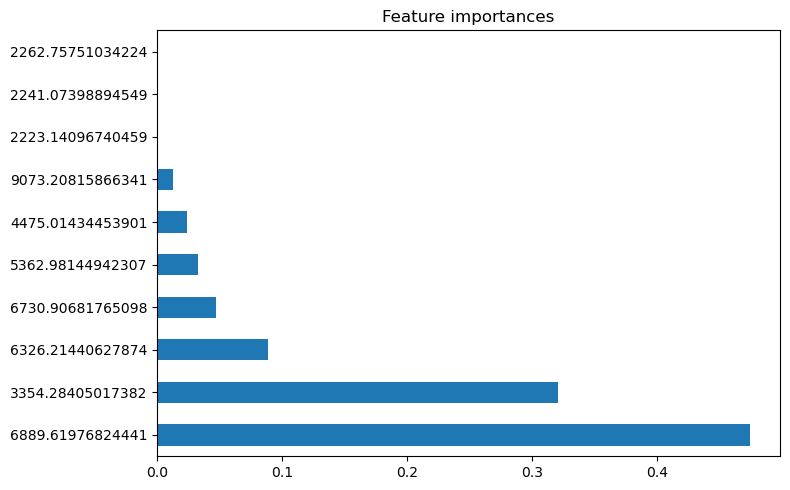

In [15]:
#Dizionario con importanza feature
feature_importances = dtc.feature_importances_
feature_index = X.columns
myDict = dict(zip(feature_index, feature_importances))
myDict = dict(sorted(myDict.items(), key=lambda item: item[1], reverse = True))

#Plot delle 15 feature con più importanza
series = pd.Series(data=myDict.values(), index=myDict.keys()).head(10)
series.plot(kind="barh", figsize=(8, 5), title=f"Feature importances", legend=None)
plt.tight_layout()
plt.show()

In [16]:
dtc_cv_scores = cross_val_score(estimator=dtc, X=X_train, y=y_train, 
                                 scoring="accuracy", cv=skfold, n_jobs=N_JOBS, verbose=1)
print(f"Mean CV accuracy: {dtc_cv_scores.mean():.4f} +/- {dtc_cv_scores.std():.4f}")
dtc_cv_scores

Mean CV accuracy: 0.9353 +/- 0.0494


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


array([0.92307692, 0.92307692, 0.92307692, 0.83333333, 0.91666667,
       1.        , 1.        , 0.91666667, 0.91666667, 1.        ])

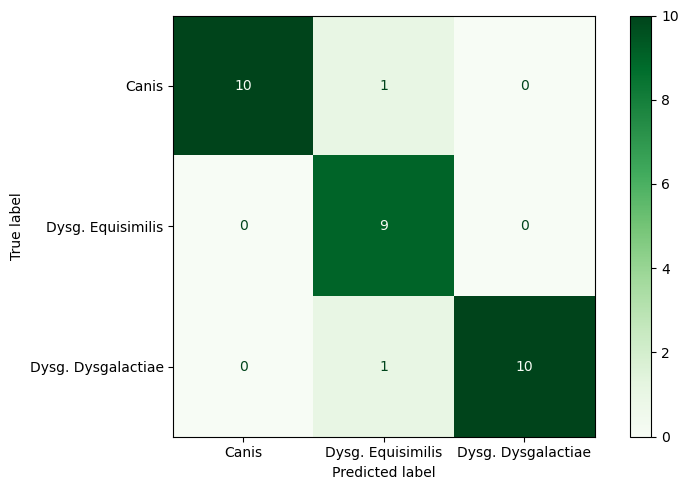

In [17]:
fig, ax = plt.subplots(figsize=(8, 5))
plot_confusion_matrix(estimator=dtc, X=X_test, y_true=y_test, cmap='Greens', display_labels=class_names, ax=ax)
plt.tight_layout()
plt.show()

In [18]:
y_pred = dtc.predict(X=X_test)
accuracy_tree = accuracy_score(y_true=y_test, y_pred=y_pred)

y_pred_train = dtc.predict(X=X_train)
accuracy_train = accuracy_score(y_true=y_train, y_pred=y_pred_train)
print(f"train accuracy score: {accuracy_train:.4f}")

report = classification_report(y_true=y_test, y_pred=y_pred)
print(report)

train accuracy score: 1.0000
              precision    recall  f1-score   support

           0       1.00      0.91      0.95        11
           1       0.82      1.00      0.90         9
           2       1.00      0.91      0.95        11

    accuracy                           0.94        31
   macro avg       0.94      0.94      0.93        31
weighted avg       0.95      0.94      0.94        31



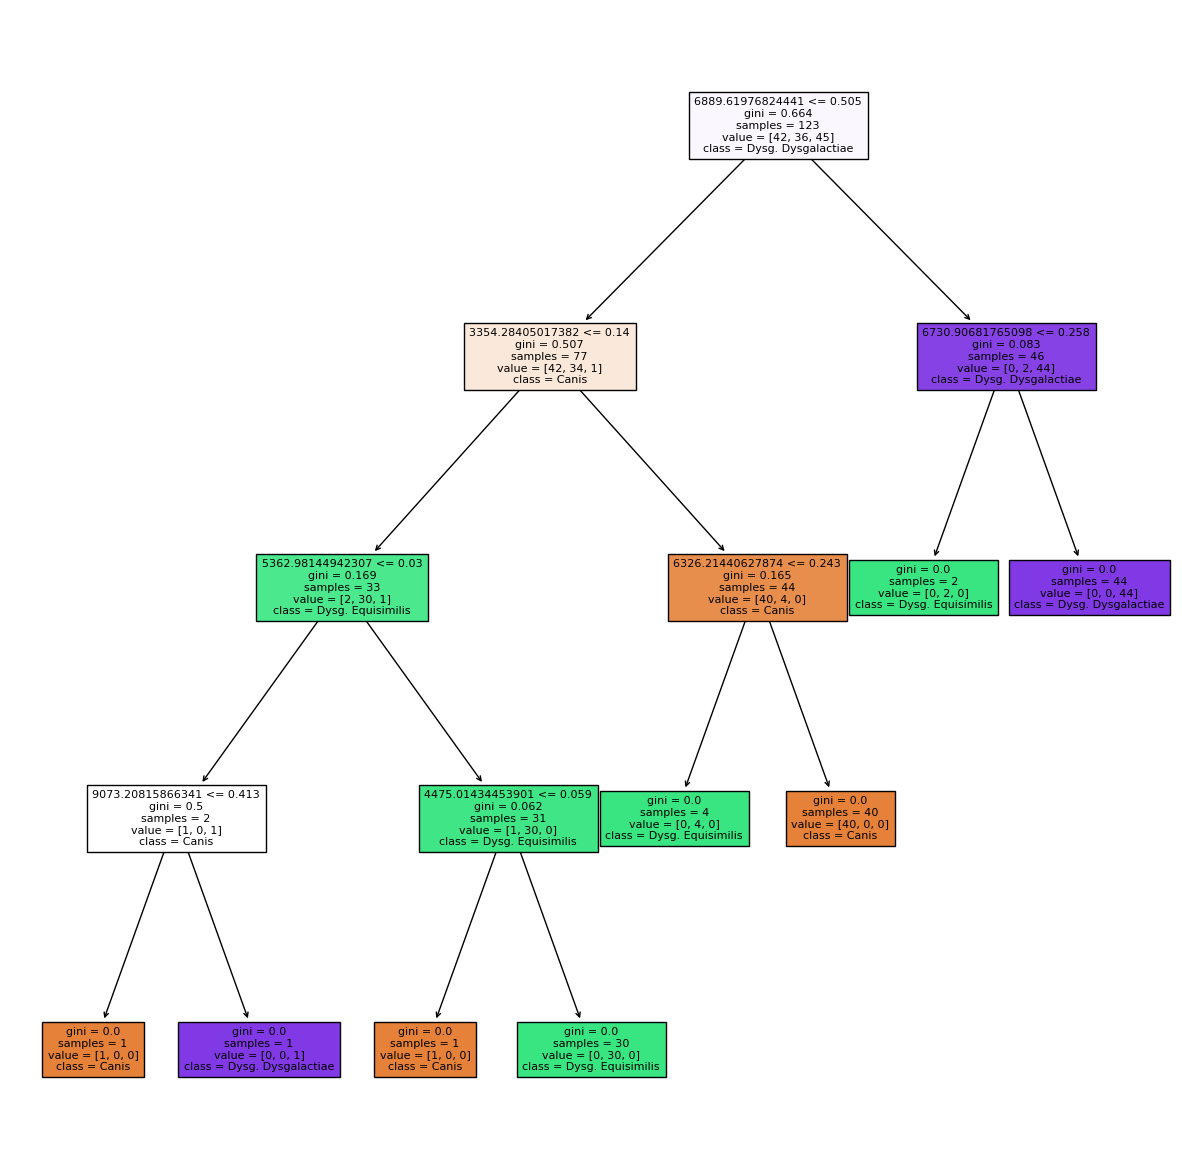

In [19]:
feature_names = feature_index

plt.figure(figsize=(15, 15))
plot_tree(decision_tree=dtc, 
          feature_names=feature_names, 
          class_names=class_names, 
          filled=True, fontsize=8)
plt.show()

#### K-nn with all maldi

In [20]:
knn_scores = []

for k in range(1, X_train.shape[0], 2):
    # model definition and training
    knn =  KNeighborsClassifier(n_neighbors=k)
    knn.fit(X=X_train, y=y_train)
    # compute accuracy on test set
    accuracy = knn.score(X_test, y_test)
    # store the results on a list of dictionaries
    metrics = {"# neighbors": k, "accuracy": accuracy}
    knn_scores.append(metrics)

# convert the list of dictionaries to pandas dataframe
df_knn_scores = pd.DataFrame(data=knn_scores)    #molto facile eveloce da dizionario a dataframe 
df_knn_scores

,# neighbors,accuracy
0,1,0.935484
1,3,0.935484
2,5,0.903226
3,7,0.903226
4,9,0.870968
...,...,...
56,113,0.645161
57,115,0.580645
58,117,0.580645
59,119,0.387097


In [21]:
mask = df_knn_scores["accuracy"] == df_knn_scores["accuracy"].max()
knn_k = df_knn_scores['accuracy'].idxmax()
n = df_knn_scores['# neighbors'][knn_k]
df_knn_scores[mask]

,# neighbors,accuracy
0,1,0.935484
1,3,0.935484


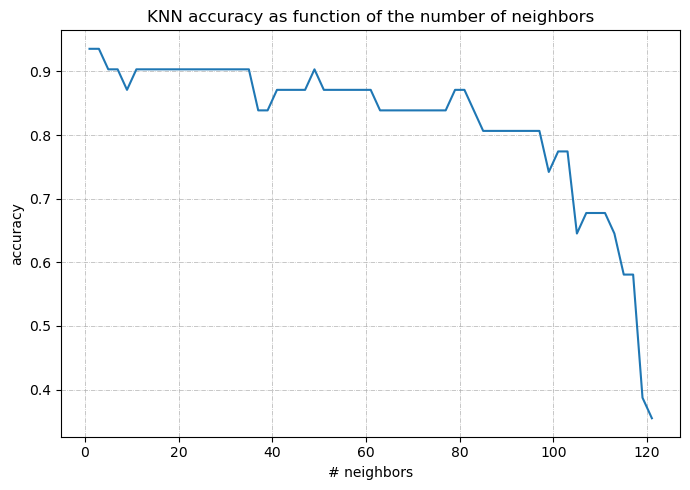

In [22]:
plt.figure(figsize=(7, 5))
plt.title("KNN accuracy as function of the number of neighbors")
sns.lineplot(x="# neighbors", y="accuracy", data=df_knn_scores)
plt.grid(linestyle='-.', linewidth=0.5)
plt.tight_layout()
plt.show()

In [23]:
knn = KNeighborsClassifier(n_neighbors=n)
knn.fit(X=X_train, y=y_train)

KNeighborsClassifier(n_neighbors=1)

In [24]:
knn_cv_scores = cross_val_score(estimator=knn, X=X_train, y=y_train, 
                                 scoring="accuracy", cv=skfold, n_jobs=N_JOBS, verbose=1)
print(f"Mean CV KNN accuracy: {knn_cv_scores.mean():.4f} +/- {knn_cv_scores.std():.4f}")
knn_cv_scores

Mean CV KNN accuracy: 0.9506 +/- 0.0549


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


array([1.        , 1.        , 0.92307692, 0.91666667, 1.        ,
       0.91666667, 1.        , 1.        , 0.83333333, 0.91666667])

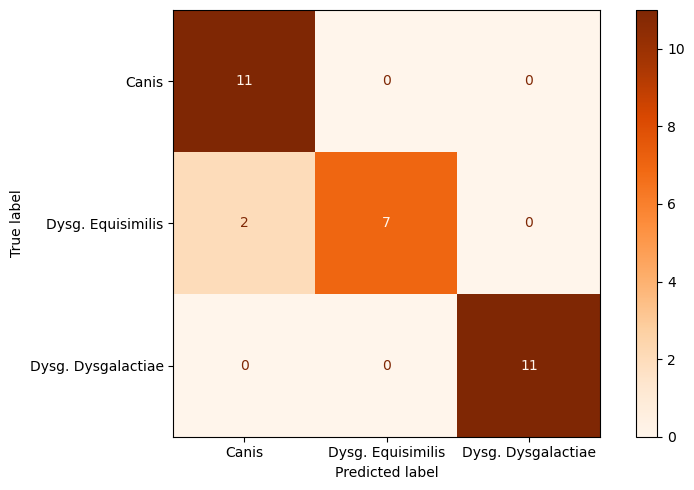

In [25]:
fig, ax = plt.subplots(figsize=(8, 5))
plot_confusion_matrix(estimator=knn, X=X_test, y_true=y_test, cmap='Oranges', display_labels=class_names, ax=ax)
plt.tight_layout()
plt.show()

In [26]:
y_pred = knn.predict(X=X_test)
accuracy_knn = accuracy_score(y_true=y_test, y_pred=y_pred)
report = classification_report(y_true=y_test, y_pred=y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.85      1.00      0.92        11
           1       1.00      0.78      0.88         9
           2       1.00      1.00      1.00        11

    accuracy                           0.94        31
   macro avg       0.95      0.93      0.93        31
weighted avg       0.95      0.94      0.93        31



#### Random Forest with all maldi

In [27]:
rm = RandomForestClassifier(oob_score=True, n_jobs=N_JOBS, random_state=RANDOM_STATE)

In [28]:
rm_cv_scores = cross_val_score(estimator=rm, X=X_train, y=y_train, 
                                 scoring="accuracy", cv=skfold, n_jobs=N_JOBS, verbose=1)
print(f"Mean CV Random Forest accuracy: {rm_cv_scores.mean():.4f} +/- {rm_cv_scores.std():.4f}")
rm_cv_scores

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


Mean CV Random Forest accuracy: 0.9756 +/- 0.0372


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.9s finished


array([0.92307692, 1.        , 1.        , 1.        , 0.91666667,
       1.        , 0.91666667, 1.        , 1.        , 1.        ])

In [29]:
n_estimator = 100
max_features = 'log2'
max_depth = 2
criterion = 'entropy'
class_weight = 'balanced_subsample'
best_rm = RandomForestClassifier(n_estimators=n_estimator, max_features=max_features, max_depth=max_depth, class_weight=class_weight, criterion=criterion, oob_score=True, n_jobs=N_JOBS, random_state=RANDOM_STATE)
best_rm.fit(X=X_train, y=y_train)

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=2, max_features='log2', n_jobs=-1,
                       oob_score=True, random_state=42)

In [30]:
best_rm_cv_scores = cross_val_score(estimator=best_rm, X=X_train, y=y_train, 
                                 scoring="accuracy", cv=skfold, n_jobs=N_JOBS, verbose=1)
print(f"Mean CV Best Random Forest accuracy: {best_rm_cv_scores.mean():.4f} +/- {best_rm_cv_scores.std():.4f}")
best_rm_cv_scores

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


Mean CV Best Random Forest accuracy: 0.9833 +/- 0.0333


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.3s finished


array([1.        , 1.        , 1.        , 1.        , 0.91666667,
       1.        , 0.91666667, 1.        , 1.        , 1.        ])

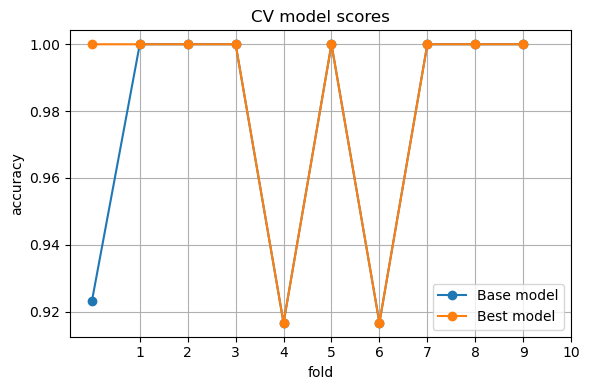

In [31]:
plt.figure(figsize=(6, 4))
plt.title("CV model scores")
plt.plot(rm_cv_scores, marker="o")
plt.plot(best_rm_cv_scores, marker="o")
plt.xticks(ticks=range(1, 11))
plt.xlabel("fold")
plt.ylabel("accuracy")
plt.legend(["Base model", "Best model"])
plt.tight_layout()
plt.grid()
plt.show()

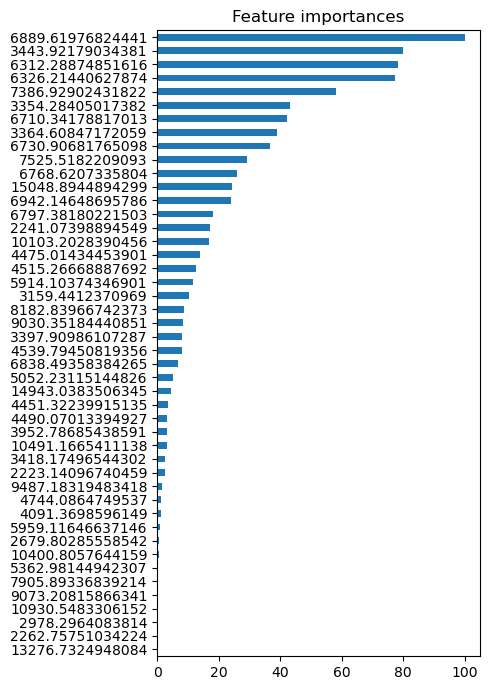

In [32]:
feature_importances_plot(model=best_rm, labels=X.columns)

In [33]:
best_rm.oob_score_

0.975609756097561

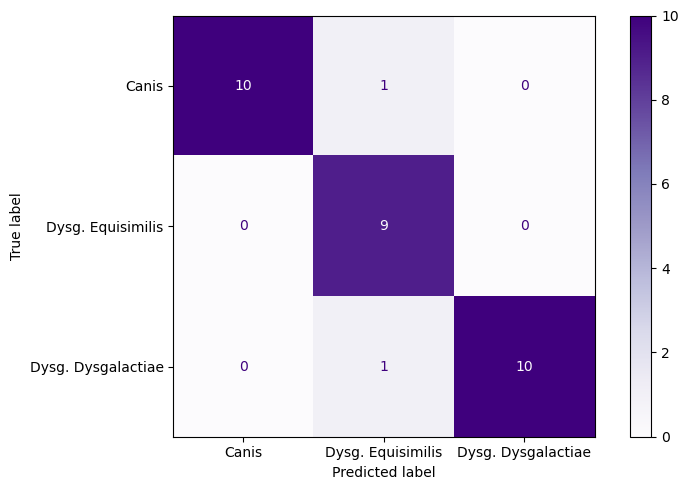

In [34]:
fig, ax = plt.subplots(figsize=(8, 5))
plot_confusion_matrix(estimator=best_rm, X=X_test, y_true=y_test, cmap='Purples', display_labels=class_names, ax=ax)
plt.tight_layout()
plt.show()

In [35]:
y_pred = best_rm.predict(X_test)
accuracy_rm = accuracy_score(y_true=y_test, y_pred=y_pred)

report = classification_report(y_true=y_test, y_pred=y_pred)
print(report)

r2_rf = r2_score(y_test, y_pred)
print('R2 score of random forest classifier on test set: {:.3f}'.format(r2_rf))

rmse_rf = mean_squared_error(y_test, y_pred, squared=False)
print('R2 score of random forest classifier on test set: {:.3f}'.format(rmse_rf))

              precision    recall  f1-score   support

           0       1.00      0.91      0.95        11
           1       0.82      1.00      0.90         9
           2       1.00      0.91      0.95        11

    accuracy                           0.94        31
   macro avg       0.94      0.94      0.93        31
weighted avg       0.95      0.94      0.94        31

R2 score of random forest classifier on test set: 0.909
R2 score of random forest classifier on test set: 0.254


## Modello con dimensionality reduction per visualizzazione(PCA)

In [36]:
y = df['target']
X = maldi

In [37]:
pipeline = Pipeline(
    steps=[
        ("MinMax", MinMaxScaler()),
        #("SS", StandardScaler()),
        ("PCA", PCA(n_components = 2))
    ]
)
pipeline
X_pca = pipeline.fit_transform(X)

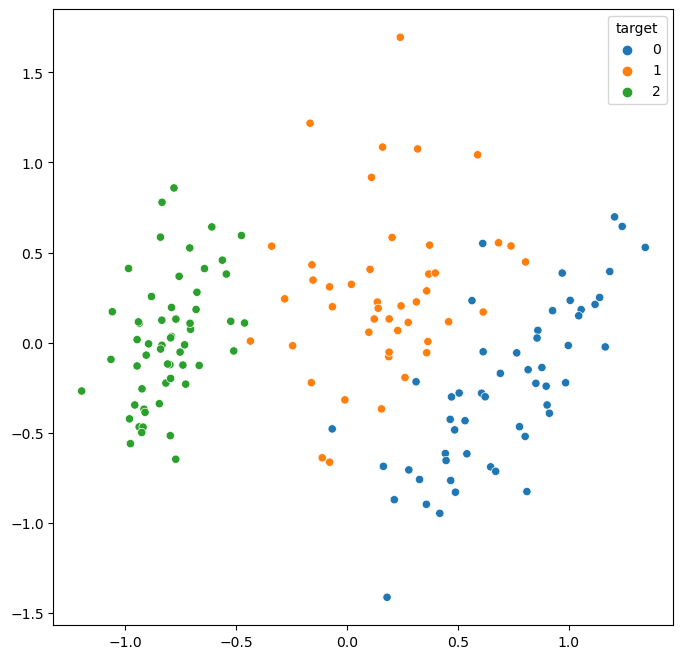

In [38]:
plt.figure(figsize=(8, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y.astype(str))
plt.savefig('view_pca_2comp_46picc_MM.png')
plt.show()

In [39]:
X_pca = pd.DataFrame(X_pca)
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)

In [40]:
print(X_train.shape)
print(X_test.shape)

(123, 2)
(31, 2)


#### Logistic regression with PCA maldi

In [41]:
logr_pca = LogisticRegression()
logr_pca.fit(X=X_train,y=y_train)

LogisticRegression()

In [42]:
skfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

In [43]:
logr_pca2_cv_scores = cross_val_score(estimator=logr_pca, X=X_train, y=y_train, 
                                 scoring="accuracy", cv=skfold, n_jobs=N_JOBS, verbose=1)
print(f"Mean CV accuracy: {logr_pca2_cv_scores.mean():.4f} +/- {logr_pca2_cv_scores.std():.4f}")
logr_pca2_cv_scores

Mean CV accuracy: 0.9026 +/- 0.0489


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


array([0.84615385, 0.92307692, 0.92307692, 0.83333333, 0.91666667,
       0.83333333, 0.91666667, 0.91666667, 0.91666667, 1.        ])

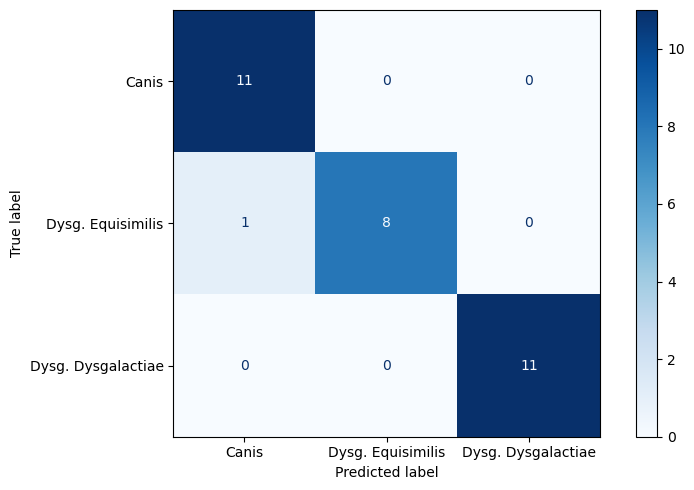

In [44]:
fig, ax = plt.subplots(figsize=(8, 5))
plot_confusion_matrix(estimator=logr_pca, X=X_test, y_true=y_test, cmap='Blues', display_labels=class_names, ax=ax)
plt.tight_layout()
plt.show()

In [45]:
y_pred = logr_pca.predict(X_test)
accuracy_logic_pca2 = logr_pca.score(X_test, y_test)

report = classification_report(y_true=y_test, y_pred=y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        11
           1       1.00      0.89      0.94         9
           2       1.00      1.00      1.00        11

    accuracy                           0.97        31
   macro avg       0.97      0.96      0.97        31
weighted avg       0.97      0.97      0.97        31



#### Decision tree with PCA maldi

In [46]:
dtc_pca = DecisionTreeClassifier(random_state=42)
dtc_pca = dtc_pca.fit(X=X_train, y=y_train)
dtc_pca

DecisionTreeClassifier(random_state=42)

In [47]:
print(f"Profonfità albero: {dtc_pca.get_depth()}")

Profonfità albero: 6


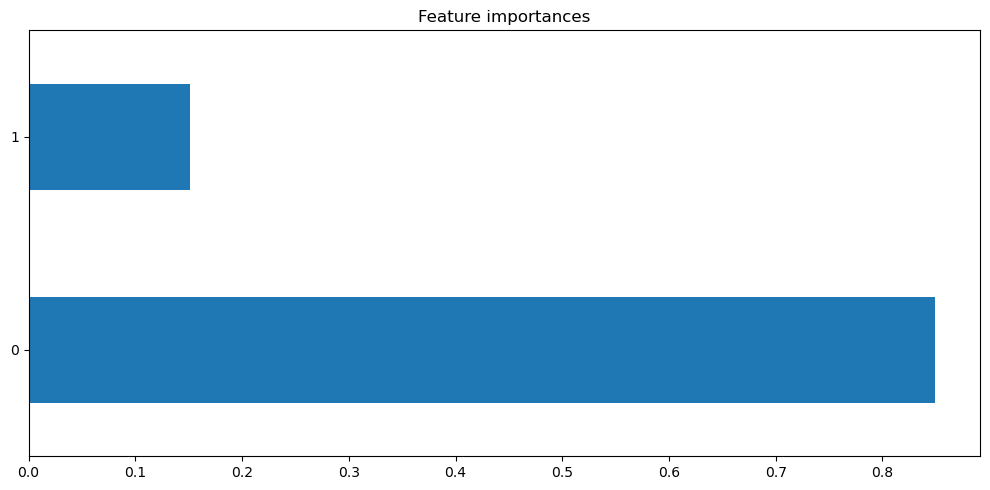

In [48]:
feature_importances = dtc_pca.feature_importances_
feature_index = X_pca.columns
myDict = dict(zip(feature_index, feature_importances))
myDict = dict(sorted(myDict.items(), key=lambda item: item[1], reverse = True))

series = pd.Series(data=myDict.values(), index=myDict.keys()).head(10)
series.plot(kind="barh", figsize=(10, 5), title=f"Feature importances", legend=None)
plt.tight_layout()
plt.show()

In [49]:
dtc_pca2_cv_scores = cross_val_score(estimator=dtc_pca, X=X_train, y=y_train, 
                                 scoring="accuracy", cv=skfold, n_jobs=N_JOBS, verbose=1)
print(f"Mean CV accuracy: {dtc_pca2_cv_scores.mean():.4f} +/- {dtc_pca2_cv_scores.std():.4f}")
dtc_pca2_cv_scores

Mean CV accuracy: 0.8769 +/- 0.0779


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished


array([0.92307692, 0.92307692, 0.92307692, 0.83333333, 0.83333333,
       0.91666667, 0.75      , 0.91666667, 0.75      , 1.        ])

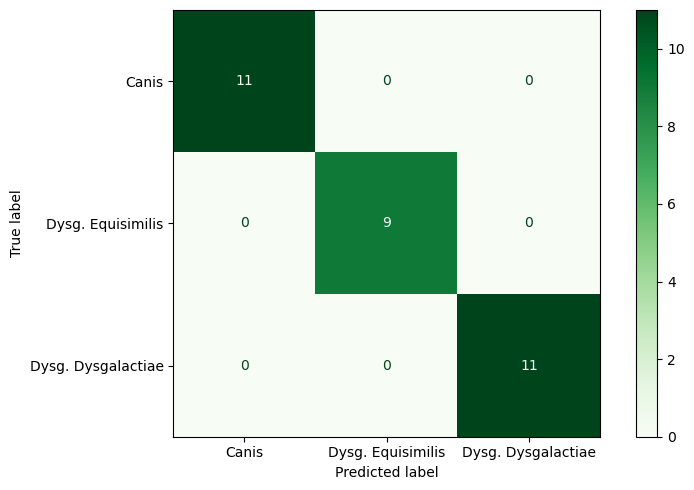

In [50]:
fig, ax = plt.subplots(figsize=(8, 5))
plot_confusion_matrix(estimator=dtc_pca, X=X_test, y_true=y_test, cmap='Greens', display_labels=class_names, ax=ax)
plt.tight_layout()
plt.show()

In [51]:
y_pred = dtc_pca.predict(X=X_test)
accuracy_tree_pca2 = accuracy_score(y_true=y_test, y_pred=y_pred)

report = classification_report(y_true=y_test, y_pred=y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        31
   macro avg       1.00      1.00      1.00        31
weighted avg       1.00      1.00      1.00        31



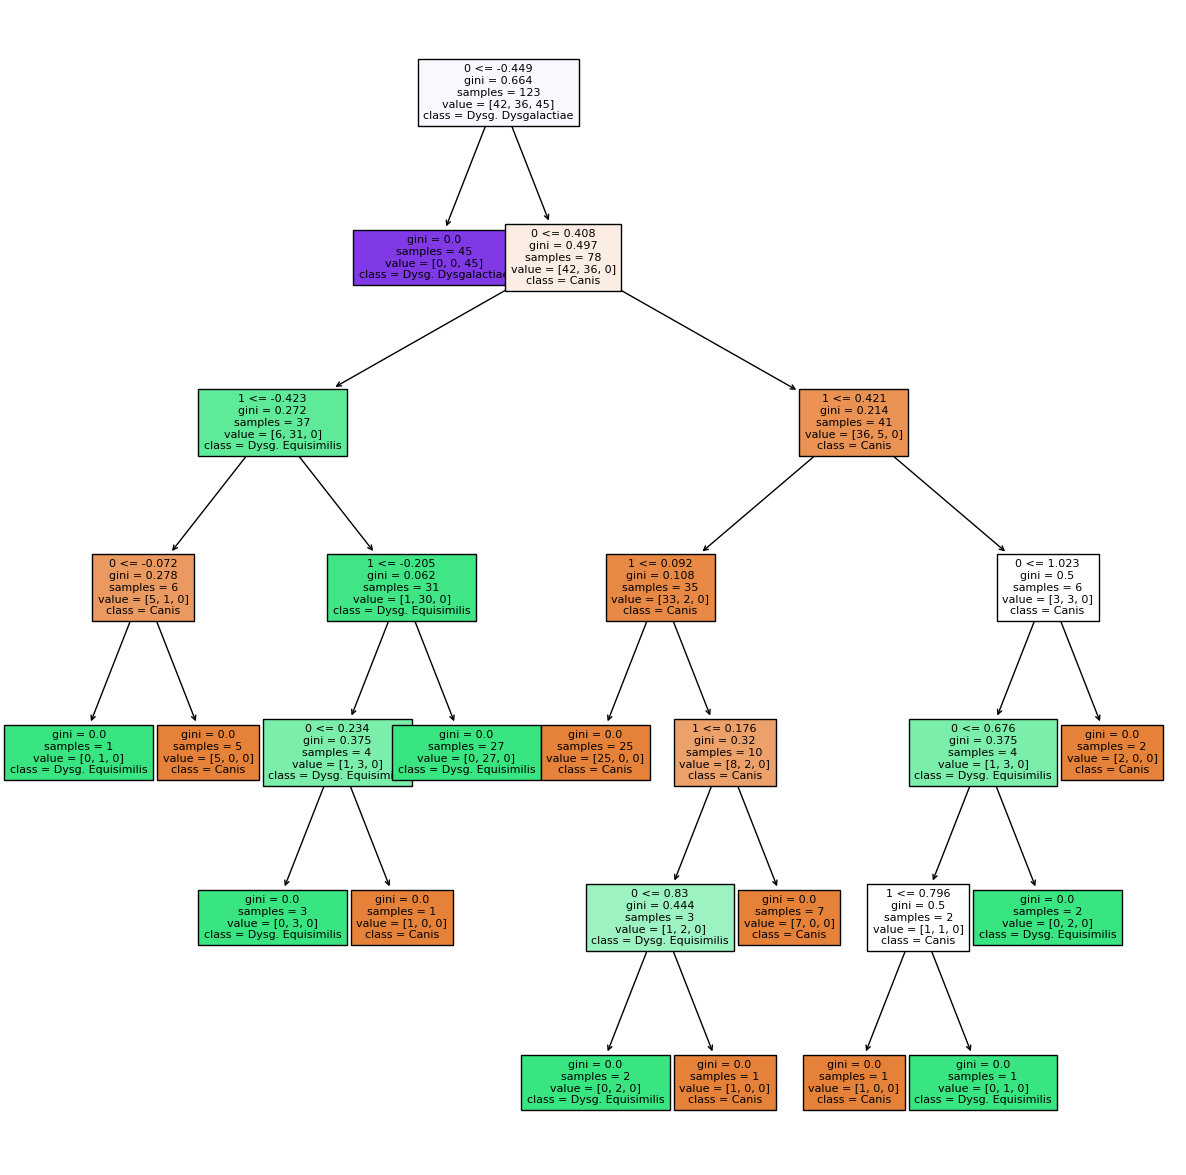

In [52]:
feature_names = feature_index

plt.figure(figsize=(15, 15))
plot_tree(decision_tree=dtc_pca, 
          feature_names=feature_names, 
          class_names=class_names, 
          filled=True, fontsize=8)
plt.show()

#### K-nn with PCA maldi

In [53]:
knn_scores = []

for k in range(1, X_train.shape[0], 2):
    # model definition and training
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X=X_train, y=y_train)
    # compute accuracy on test set
    accuracy = knn.score(X_test, y_test)
    # store the results on a list of dictionaries
    metrics = {"# neighbors": k, "accuracy": accuracy}
    knn_scores.append(metrics)

# convert the list of dictionaries to pandas dataframe
df_knn_scores_pca = pd.DataFrame(data=knn_scores)    #molto facile eveloce da dizionario a dataframe 
df_knn_scores_pca

,# neighbors,accuracy
0,1,1.000000
1,3,0.967742
2,5,1.000000
3,7,0.967742
4,9,0.967742
...,...,...
56,113,0.709677
57,115,0.709677
58,117,0.709677
59,119,0.516129


In [54]:
mask = df_knn_scores_pca["accuracy"] == df_knn_scores_pca["accuracy"].max()   
knn_k = df_knn_scores_pca["accuracy"].idxmax()
n = df_knn_scores_pca['# neighbors'][knn_k]
df_knn_scores_pca[mask]

,# neighbors,accuracy
0,1,1.0
2,5,1.0


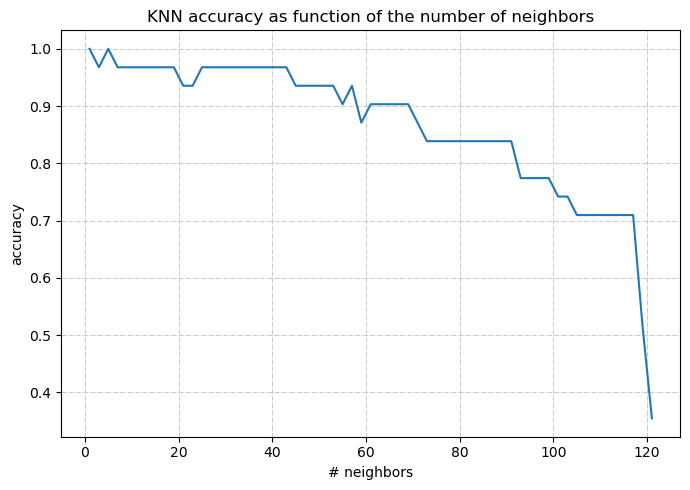

In [55]:
plt.figure(figsize=(7, 5))
plt.title("KNN accuracy as function of the number of neighbors")
sns.lineplot(x="# neighbors", y="accuracy", data=df_knn_scores_pca)
plt.grid(linestyle='-.', linewidth=0.5)
plt.tight_layout()
plt.show()

In [56]:
knn_pca = KNeighborsClassifier(n_neighbors=n)
knn_pca.fit(X=X_train, y=y_train)

KNeighborsClassifier(n_neighbors=1)

In [57]:
knn_pca2_cv_scores = cross_val_score(estimator=knn_pca, X=X_train, y=y_train, 
                                 scoring="accuracy", cv=skfold, n_jobs=N_JOBS, verbose=1)
print(f"Mean CV KNN accuracy: {knn_pca2_cv_scores.mean():.4f} +/- {knn_pca2_cv_scores.std():.4f}")
knn_pca2_cv_scores

Mean CV KNN accuracy: 0.8936 +/- 0.0395


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished


array([0.92307692, 0.92307692, 0.92307692, 0.91666667, 0.83333333,
       0.91666667, 0.91666667, 0.91666667, 0.83333333, 0.83333333])

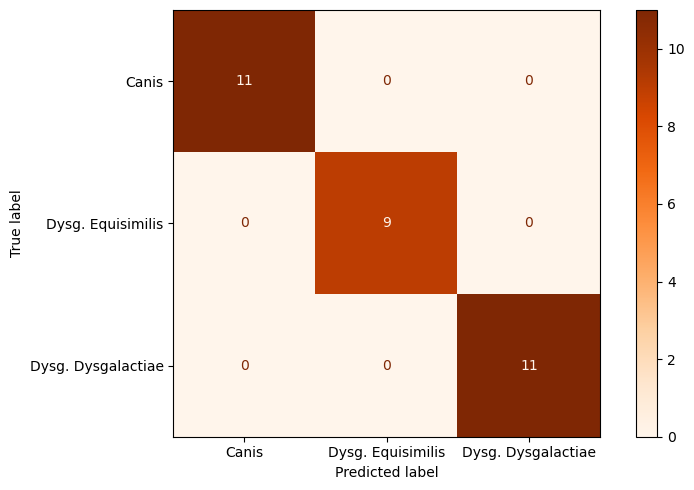

In [58]:
fig, ax = plt.subplots(figsize=(8, 5))
plot_confusion_matrix(estimator=knn_pca, X=X_test, y_true=y_test, cmap='Oranges', display_labels=class_names, ax=ax)
plt.tight_layout()
plt.show()

In [59]:
y_pred = knn_pca.predict(X=X_test)
accuracy_knn_pca2 = accuracy_score(y_true=y_test, y_pred=y_pred)

report = classification_report(y_true=y_test, y_pred=y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00        11

    accuracy                           1.00        31
   macro avg       1.00      1.00      1.00        31
weighted avg       1.00      1.00      1.00        31



#### Random Forest with pca maldi

In [60]:
rm_pca = RandomForestClassifier(oob_score=True, n_jobs=N_JOBS, random_state=RANDOM_STATE)
rm_pca

RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=42)

In [61]:
rm_cv_scores = cross_val_score(estimator=rm_pca, X=X_train, y=y_train, 
                                 scoring="accuracy", cv=skfold, n_jobs=N_JOBS, verbose=1)
print(f"Mean CV Random Forest accuracy: {rm_cv_scores.mean():.4f} +/- {rm_cv_scores.std():.4f}")
rm_cv_scores

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


Mean CV Random Forest accuracy: 0.9006 +/- 0.0728


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.8s finished


array([0.92307692, 1.        , 1.        , 0.83333333, 0.83333333,
       0.83333333, 0.83333333, 0.91666667, 0.83333333, 1.        ])

In [62]:
n_estimator = 50
max_features = 'log2'
max_depth = None
criterion = 'gini'
class_weight = 'balanced'

best_rm_pca = RandomForestClassifier(n_estimators=n_estimator, max_features=max_features, max_depth=max_depth, class_weight=class_weight, criterion=criterion, oob_score=True, n_jobs=N_JOBS, random_state=RANDOM_STATE)
best_rm_pca.fit(X=X_train, y=y_train)

RandomForestClassifier(class_weight='balanced', max_features='log2',
                       n_estimators=50, n_jobs=-1, oob_score=True,
                       random_state=42)

In [63]:
best_pca2_rm_cv_scores = cross_val_score(estimator=best_rm_pca, X=X_train, y=y_train, 
                                 scoring="accuracy", cv=skfold, n_jobs=N_JOBS, verbose=1)
print(f"Mean CV Best Random Forest accuracy: {best_pca2_rm_cv_scores.mean():.4f} +/- {best_pca2_rm_cv_scores.std():.4f}")
best_pca2_rm_cv_scores

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


Mean CV Best Random Forest accuracy: 0.8846 +/- 0.0674


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.2s finished


array([0.92307692, 1.        , 0.92307692, 0.83333333, 0.83333333,
       0.83333333, 0.83333333, 0.83333333, 0.83333333, 1.        ])

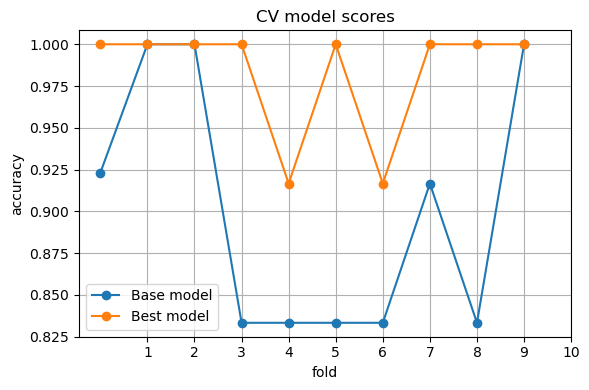

In [64]:
plt.figure(figsize=(6, 4))
plt.title("CV model scores")
plt.plot(rm_cv_scores, marker="o")
plt.plot(best_rm_cv_scores, marker="o")
plt.xticks(ticks=range(1, 11))
plt.xlabel("fold")
plt.ylabel("accuracy")
plt.legend(["Base model", "Best model"])
plt.tight_layout()
plt.grid()
plt.show()

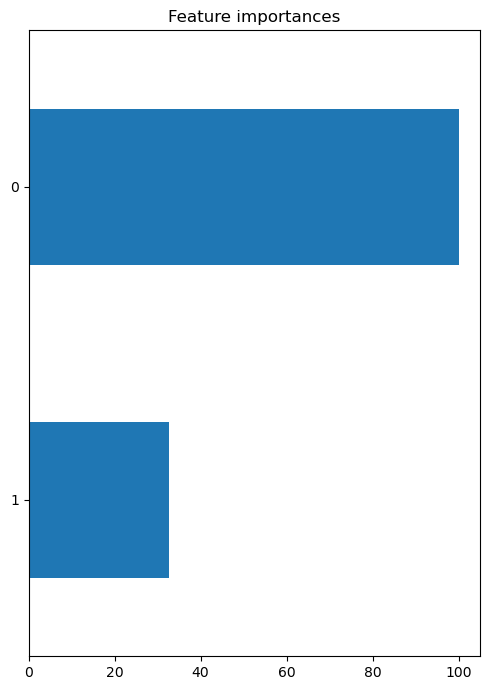

In [65]:
feature_importances_plot(model=best_rm_pca, labels=X_pca.columns)

In [66]:
best_rm_pca.oob_score_

0.8943089430894309

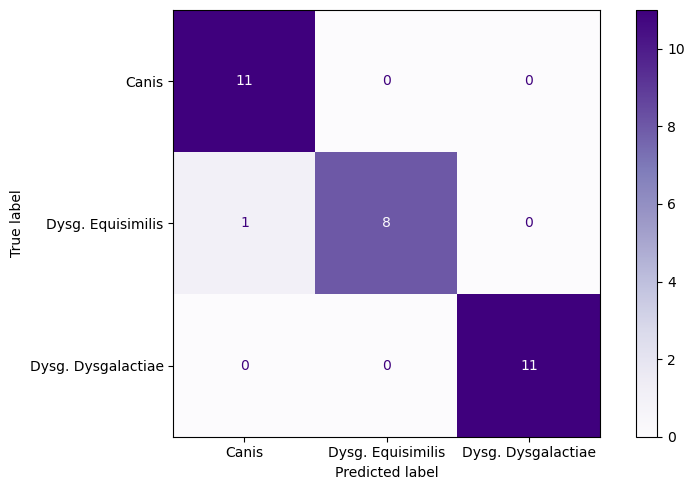

In [67]:
fig, ax = plt.subplots(figsize=(8, 5))
plot_confusion_matrix(estimator=best_rm_pca, X=X_test, y_true=y_test, cmap='Purples', display_labels=class_names, ax=ax)
plt.tight_layout()
plt.show()

In [68]:
y_pred = best_rm_pca.predict(X_test)
accuracy_rm_pca2 = accuracy_score(y_true=y_test, y_pred=y_pred)
report = classification_report(y_true=y_test, y_pred=y_pred)
print(report)

r2_rf = r2_score(y_test, y_pred)
print('R2 score of random forest classifier with PCA on test set: {:.3f}'.format(r2_rf))

rmse_rf = mean_squared_error(y_test, y_pred, squared=False)
print('R2 score of random forest classifier with PCA on test set: {:.3f}'.format(rmse_rf))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        11
           1       1.00      0.89      0.94         9
           2       1.00      1.00      1.00        11

    accuracy                           0.97        31
   macro avg       0.97      0.96      0.97        31
weighted avg       0.97      0.97      0.97        31

R2 score of random forest classifier with PCA on test set: 0.955
R2 score of random forest classifier with PCA on test set: 0.180


## Modello con dimensionality reduction (PCA)

In [69]:
y = df['target']
X = maldi

[pca] >Column labels are auto-completed.
[pca] >Row labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [46] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [19] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [46] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[19]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


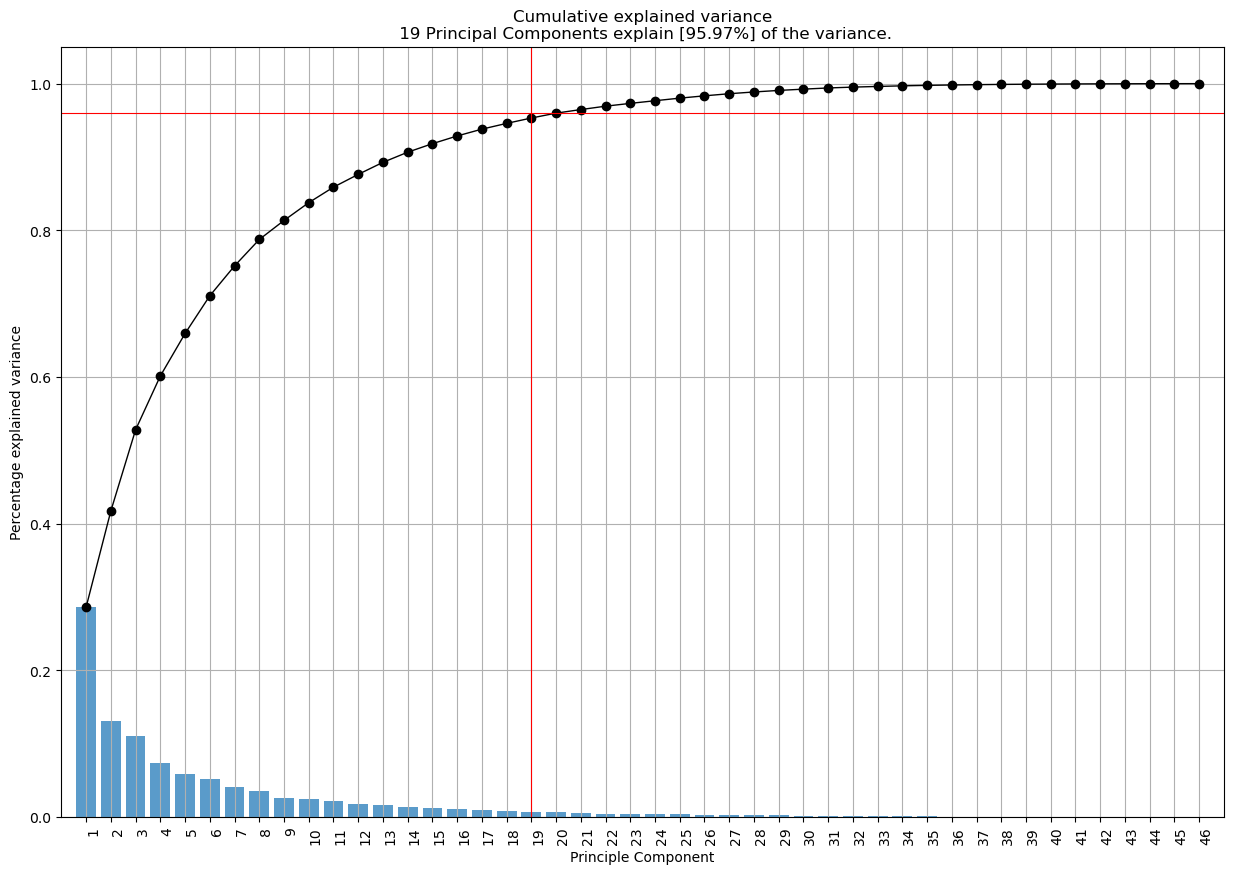

<Figure size 640x480 with 0 Axes>

In [70]:
from pca import pca
model = pca(n_components=0.95)
minMax = MinMaxScaler()
ss = StandardScaler()

X_mm = minMax.fit_transform(X)
X_pca2 = model.fit_transform(X_mm)

#X_ss = ss.fit_transform(X)
#X_pca2 = model.fit_transform(X_ss)

#X_pca2 = model.fit_transform(X)
fig, ax = model.plot()
fig.savefig('pca_ncomponents_46picc_95_MM.png')

In [71]:
pipeline = Pipeline(
    steps=[
        ("MinMax", MinMaxScaler()),
        #("SS", StandardScaler()),
        ("PCA", PCA(n_components = 0.95))
    ]
)
pipeline

Pipeline(steps=[('MinMax', MinMaxScaler()), ('PCA', PCA(n_components=0.95))])

In [72]:
X_pca = pipeline.fit_transform(X)
X_pca = pd.DataFrame(X_pca)
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)

In [73]:
print(X_train.shape)
print(X_test.shape)

(123, 19)
(31, 19)


#### Logistic regression with PCA maldi

In [74]:
logr_pca = LogisticRegression()
logr_pca.fit(X=X_train,y=y_train)

LogisticRegression()

In [75]:
logr_pca_cv_scores = cross_val_score(estimator=logr_pca, X=X_train, y=y_train, 
                                 scoring="accuracy", cv=skfold, n_jobs=N_JOBS, verbose=1)
print(f"Mean CV accuracy: {logr_pca_cv_scores.mean():.4f} +/- {logr_pca_cv_scores.std():.4f}")
logr_pca_cv_scores

Mean CV accuracy: 0.9603 +/- 0.0526


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.2s finished


array([1.        , 0.92307692, 0.84615385, 1.        , 1.        ,
       0.91666667, 0.91666667, 1.        , 1.        , 1.        ])

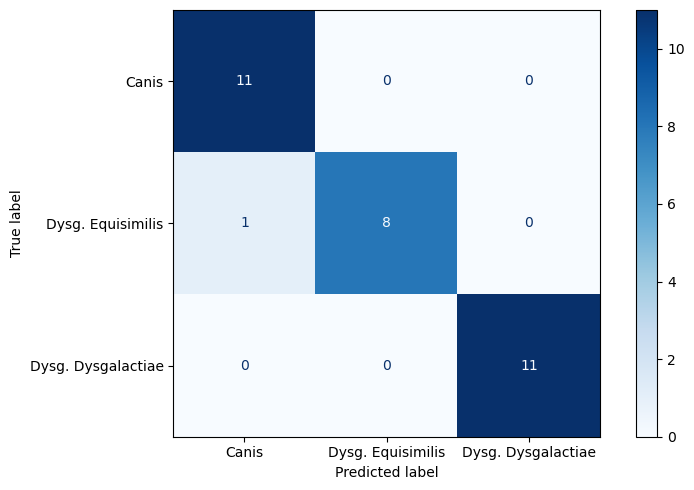

In [76]:
fig, ax = plt.subplots(figsize=(8, 5))
plot_confusion_matrix(estimator=logr_pca, X=X_test, y_true=y_test, cmap='Blues', display_labels=class_names, ax=ax)
plt.tight_layout()
plt.show()

In [77]:
y_pred = logr_pca.predict(X_test)
accuracy_logic_pca = logr_pca.score(X_test, y_test)

report = classification_report(y_true=y_test, y_pred=y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        11
           1       1.00      0.89      0.94         9
           2       1.00      1.00      1.00        11

    accuracy                           0.97        31
   macro avg       0.97      0.96      0.97        31
weighted avg       0.97      0.97      0.97        31



#### Decision tree with PCA maldi

In [78]:
dtc_pca = DecisionTreeClassifier(random_state=RANDOM_STATE)
dtc_pca = dtc_pca.fit(X=X_train, y=y_train)
dtc_pca

DecisionTreeClassifier(random_state=42)

In [79]:
print(f"Profonfità albero: {dtc_pca.get_depth()}")

Profonfità albero: 4


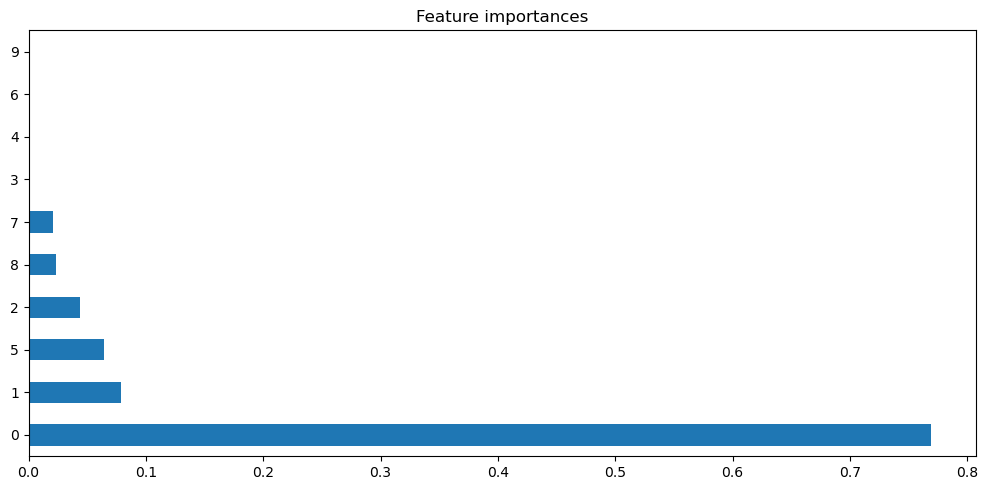

In [80]:
feature_importances = dtc_pca.feature_importances_
feature_index = X_pca.columns
myDict = dict(zip(feature_index, feature_importances))
myDict = dict(sorted(myDict.items(), key=lambda item: item[1], reverse = True))

series = pd.Series(data=myDict.values(), index=myDict.keys()).head(10)
series.plot(kind="barh", figsize=(10, 5), title=f"Feature importances", legend=None)
plt.tight_layout()
plt.show()

In [81]:
dtc_pca_cv_scores = cross_val_score(estimator=dtc_pca, X=X_train, y=y_train, 
                                 scoring="accuracy", cv=skfold, n_jobs=N_JOBS, verbose=1)
print(f"Mean CV accuracy: {dtc_pca_cv_scores.mean():.4f} +/- {dtc_pca_cv_scores.std():.4f}")
dtc_pca_cv_scores

Mean CV accuracy: 0.9179 +/- 0.0746


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


array([0.92307692, 1.        , 0.92307692, 1.        , 0.75      ,
       0.91666667, 0.91666667, 1.        , 0.83333333, 0.91666667])

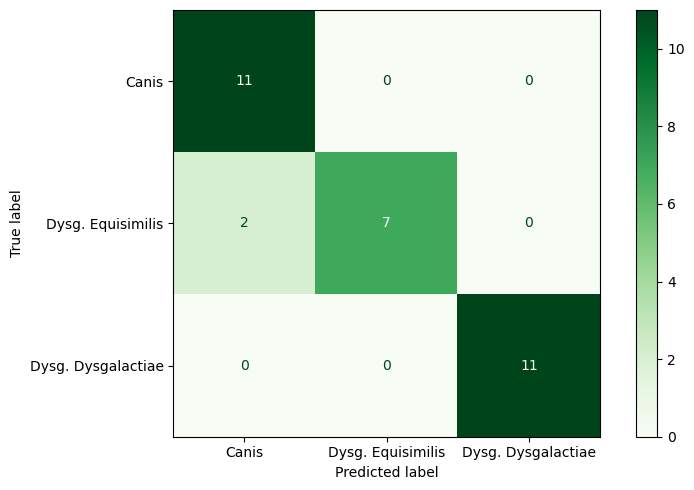

In [82]:
fig, ax = plt.subplots(figsize=(8, 5))
plot_confusion_matrix(estimator=dtc_pca, X=X_test, y_true=y_test, cmap='Greens', display_labels=class_names, ax=ax)
plt.tight_layout()
plt.show()

In [83]:
y_pred = dtc_pca.predict(X=X_test)
accuracy_tree_pca = accuracy_score(y_true=y_test, y_pred=y_pred)

report = classification_report(y_true=y_test, y_pred=y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.85      1.00      0.92        11
           1       1.00      0.78      0.88         9
           2       1.00      1.00      1.00        11

    accuracy                           0.94        31
   macro avg       0.95      0.93      0.93        31
weighted avg       0.95      0.94      0.93        31



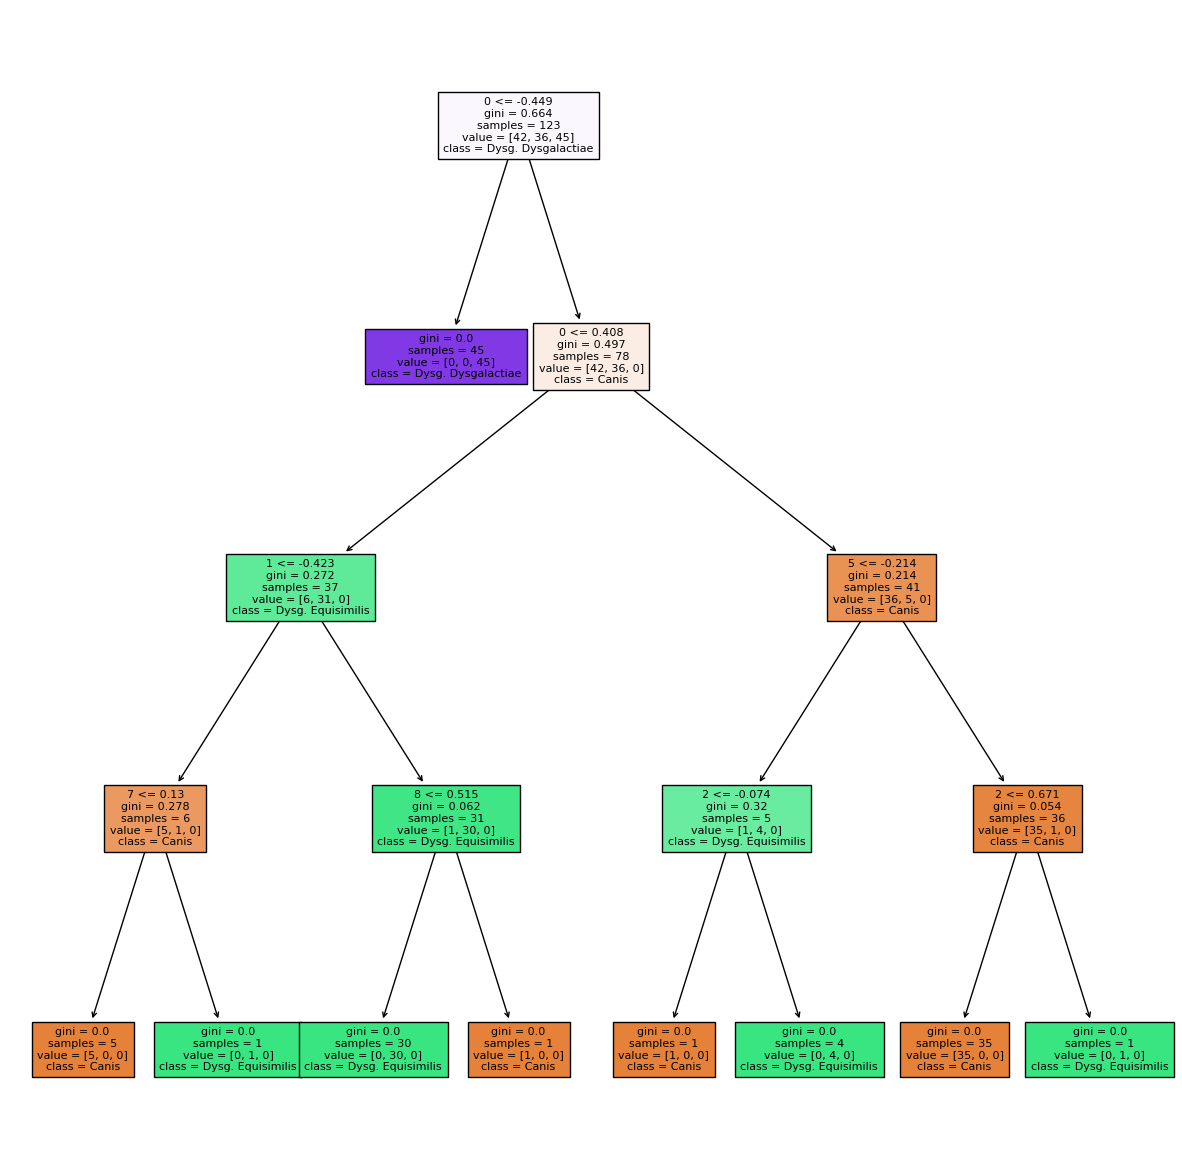

In [84]:
feature_names = feature_index

plt.figure(figsize=(15, 15))
plot_tree(decision_tree=dtc_pca, 
          feature_names=feature_names, 
          class_names=class_names, 
          filled=True, fontsize=8)
plt.show()

#### K-nn with PCA maldi

In [85]:
knn_scores = []

for k in range(1, X_train.shape[0], 2):
    # model definition and training
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X=X_train, y=y_train)
    # compute accuracy on test set
    accuracy = knn.score(X_test, y_test)
    # store the results on a list of dictionaries
    metrics = {"# neighbors": k, "accuracy": accuracy}
    knn_scores.append(metrics)

# convert the list of dictionaries to pandas dataframe
df_knn_scores_pca = pd.DataFrame(data=knn_scores)    #molto facile eveloce da dizionario a dataframe 
df_knn_scores_pca

,# neighbors,accuracy
0,1,0.967742
1,3,0.967742
2,5,0.935484
3,7,0.903226
4,9,0.903226
...,...,...
56,113,0.645161
57,115,0.645161
58,117,0.483871
59,119,0.354839


In [86]:
mask = df_knn_scores_pca["accuracy"] == df_knn_scores_pca["accuracy"].max()   
knn_k = df_knn_scores_pca["accuracy"].idxmax()
n = df_knn_scores_pca['# neighbors'][knn_k]
df_knn_scores_pca[mask]

,# neighbors,accuracy
0,1,0.967742
1,3,0.967742


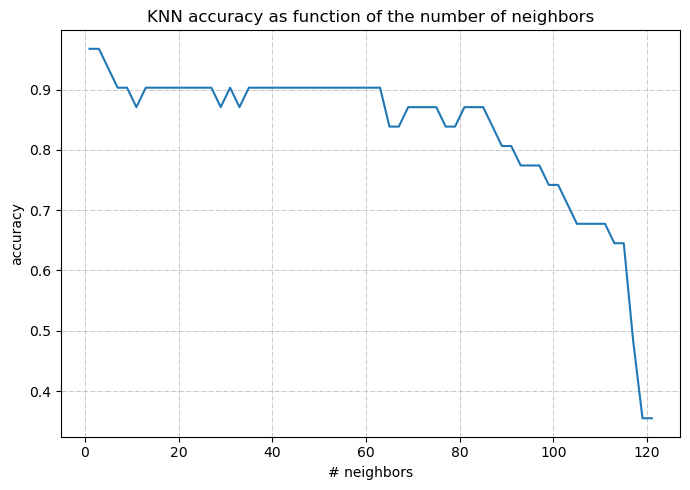

In [87]:
plt.figure(figsize=(7, 5))
plt.title("KNN accuracy as function of the number of neighbors")
sns.lineplot(x="# neighbors", y="accuracy", data=df_knn_scores_pca)
plt.grid(linestyle='-.', linewidth=0.5)
plt.tight_layout()
plt.show()

In [88]:
knn_pca = KNeighborsClassifier(n_neighbors=n)
knn_pca.fit(X=X_train, y=y_train)

KNeighborsClassifier(n_neighbors=1)

In [89]:
knn_pca_cv_scores = cross_val_score(estimator=knn_pca, X=X_train, y=y_train, 
                                 scoring="accuracy", cv=skfold, n_jobs=N_JOBS, verbose=1)
print(f"Mean CV KNN accuracy: {knn_pca_cv_scores.mean():.4f} +/- {knn_pca_cv_scores.std():.4f}")
knn_pca_cv_scores

Mean CV KNN accuracy: 0.9506 +/- 0.0549


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


array([1.        , 1.        , 0.92307692, 0.91666667, 1.        ,
       0.91666667, 0.91666667, 1.        , 0.83333333, 1.        ])

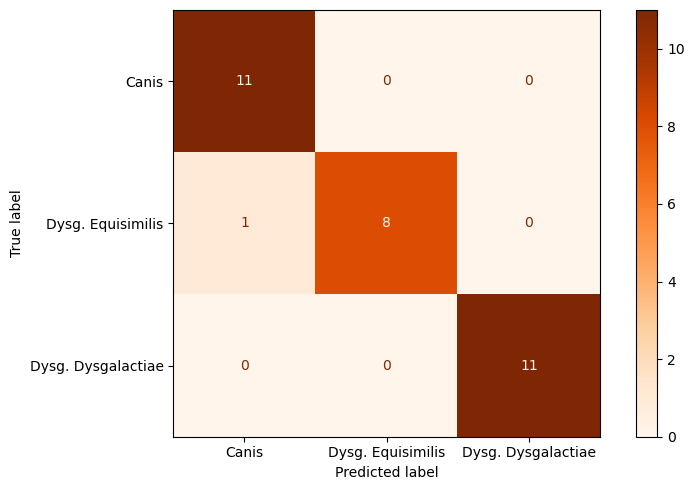

In [90]:
fig, ax = plt.subplots(figsize=(8, 5))
plot_confusion_matrix(estimator=knn_pca, X=X_test, y_true=y_test, cmap='Oranges', display_labels=class_names, ax=ax)
plt.tight_layout()
plt.show()

In [91]:
y_pred = knn_pca.predict(X=X_test)
accuracy_knn_pca = accuracy_score(y_true=y_test, y_pred=y_pred)

report = classification_report(y_true=y_test, y_pred=y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        11
           1       1.00      0.89      0.94         9
           2       1.00      1.00      1.00        11

    accuracy                           0.97        31
   macro avg       0.97      0.96      0.97        31
weighted avg       0.97      0.97      0.97        31



#### Random Forest with pca maldi

In [92]:
rm_pca = RandomForestClassifier(oob_score=True, n_jobs=N_JOBS, random_state=RANDOM_STATE)
rm_pca

RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=42)

In [93]:
rm_cv_scores = cross_val_score(estimator=rm_pca, X=X_train, y=y_train, 
                                 scoring="accuracy", cv=skfold, n_jobs=N_JOBS, verbose=1)
print(f"Mean CV Random Forest accuracy: {rm_cv_scores.mean():.4f} +/- {rm_cv_scores.std():.4f}")
rm_cv_scores

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


Mean CV Random Forest accuracy: 0.9429 +/- 0.0646


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.3s finished


array([0.92307692, 1.        , 0.92307692, 1.        , 0.83333333,
       0.91666667, 1.        , 1.        , 0.83333333, 1.        ])

In [94]:
n_estimator = 200
max_features = 'sqrt'
max_depth = 5
criterion = 'gini'
class_weight = None

best_rm_pca = RandomForestClassifier(n_estimators=n_estimator, max_features=max_features, max_depth=max_depth, class_weight=class_weight, criterion=criterion, oob_score=True, n_jobs=N_JOBS, random_state=RANDOM_STATE)
best_rm_pca.fit(X=X_train, y=y_train)

RandomForestClassifier(max_depth=5, n_estimators=200, n_jobs=-1, oob_score=True,
                       random_state=42)

In [95]:
best_pca_rm_cv_scores = cross_val_score(estimator=best_rm_pca, X=X_train, y=y_train, 
                                 scoring="accuracy", cv=skfold, n_jobs=N_JOBS, verbose=1)
print(f"Mean CV Best Random Forest accuracy: {best_pca_rm_cv_scores.mean():.4f} +/- {best_pca_rm_cv_scores.std():.4f}")
best_pca_rm_cv_scores

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


Mean CV Best Random Forest accuracy: 0.9513 +/- 0.0546


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    5.8s finished


array([0.92307692, 1.        , 0.92307692, 1.        , 0.83333333,
       0.91666667, 1.        , 1.        , 0.91666667, 1.        ])

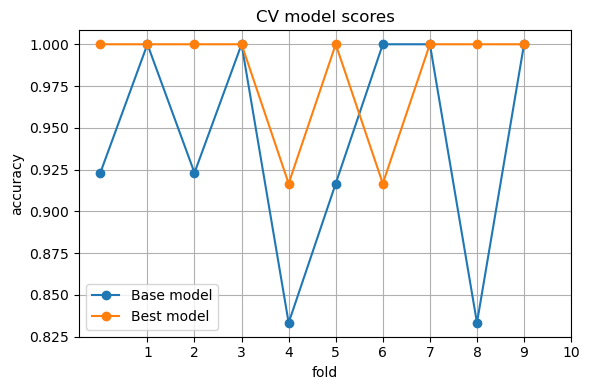

In [96]:
plt.figure(figsize=(6, 4))
plt.title("CV model scores")
plt.plot(rm_cv_scores, marker="o")
plt.plot(best_rm_cv_scores, marker="o")
plt.xticks(ticks=range(1, 11))
plt.xlabel("fold")
plt.ylabel("accuracy")
plt.legend(["Base model", "Best model"])
plt.tight_layout()
plt.grid()
plt.show()

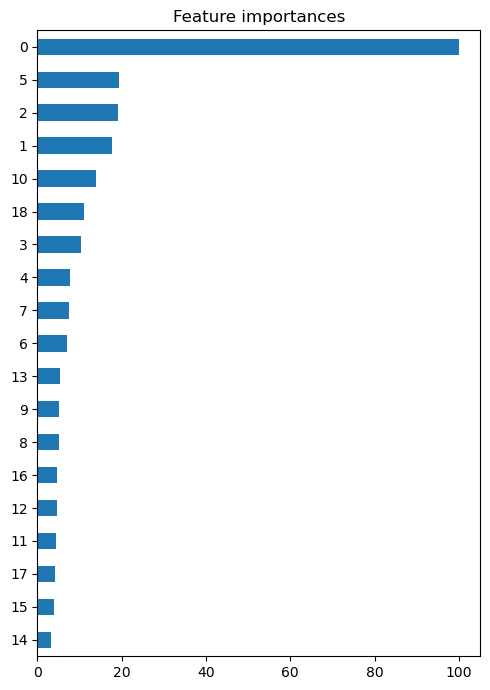

In [97]:
feature_importances_plot(model=best_rm_pca, labels=X_pca.columns)

In [98]:
best_rm_pca.oob_score_

0.926829268292683

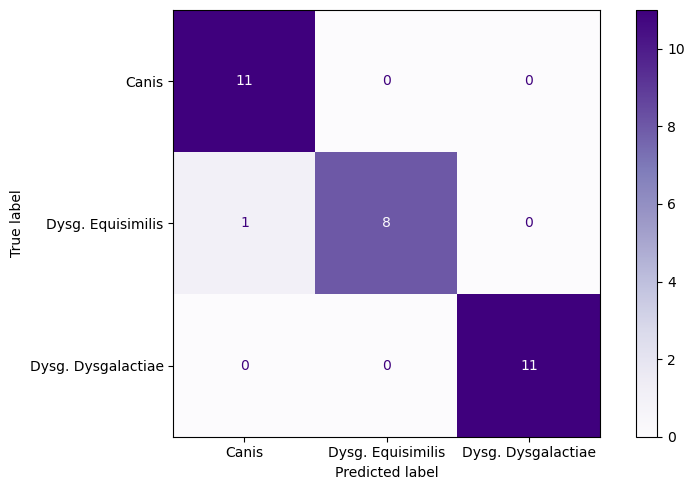

In [99]:
fig, ax = plt.subplots(figsize=(8, 5))
plot_confusion_matrix(estimator=best_rm_pca, X=X_test, y_true=y_test, cmap='Purples', display_labels=class_names, ax=ax)
plt.tight_layout()
plt.show()

In [100]:
y_pred = best_rm_pca.predict(X_test)
accuracy_rm_pca = accuracy_score(y_true=y_test, y_pred=y_pred)

report = classification_report(y_true=y_test, y_pred=y_pred)
print(report)

r2_rf = r2_score(y_test, y_pred)
print('R2 score of random forest classifier with PCA on test set: {:.3f}'.format(r2_rf))

rmse_rf = mean_squared_error(y_test, y_pred, squared=False)
print('R2 score of random forest classifier with PCA on test set: {:.3f}'.format(rmse_rf))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        11
           1       1.00      0.89      0.94         9
           2       1.00      1.00      1.00        11

    accuracy                           0.97        31
   macro avg       0.97      0.96      0.97        31
weighted avg       0.97      0.97      0.97        31

R2 score of random forest classifier with PCA on test set: 0.955
R2 score of random forest classifier with PCA on test set: 0.180


### Modello con 10 feature con correlazione più alta

In [101]:
maldi['target'] = df['target']
corr = maldi.corr()
corr = corr.sort_values('target')
top_corr_inv = corr[0:5]
top_corr = corr[-6:-1]
print(top_corr[['target']])
print(top_corr_inv[['target']])

                    target
3364.60847172059  0.753736
6730.90681765098  0.786165
6312.28874851616  0.803274
3443.92179034381  0.814983
6889.61976824441  0.848466
                    target
6326.21440627874 -0.873722
7525.5182209093  -0.600626
3354.28405017382 -0.583340
3159.4412370969  -0.482699
6710.34178817013 -0.450639


In [102]:
index = pd.concat([top_corr.index.to_series(),top_corr_inv.index.to_series()])
X = maldi[index]
y = maldi['target']

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [104]:
#Scaling dati
mm = MinMaxScaler()

X_train = mm.fit_transform(X=X_train)
X_test = mm.transform(X=X_test)

In [105]:
print(X_train.shape)
print(X_test.shape)

(123, 10)
(31, 10)


#### Logistic Regression with 10 best corr

In [106]:
logr10 = LogisticRegression()
logr10.fit(X=X_train,y=y_train)

LogisticRegression()

In [107]:
logr10_cv_scores = cross_val_score(estimator=logr10, X=X_train, y=y_train, 
                                 scoring="accuracy", cv=skfold, n_jobs=N_JOBS, verbose=1)
print(f"Mean CV accuracy: {logr10_cv_scores.mean():.4f} +/- {logr10_cv_scores.std():.4f}")
logr10_cv_scores

Mean CV accuracy: 0.9596 +/- 0.0762


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


array([1.        , 0.92307692, 0.92307692, 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.75      , 1.        ])

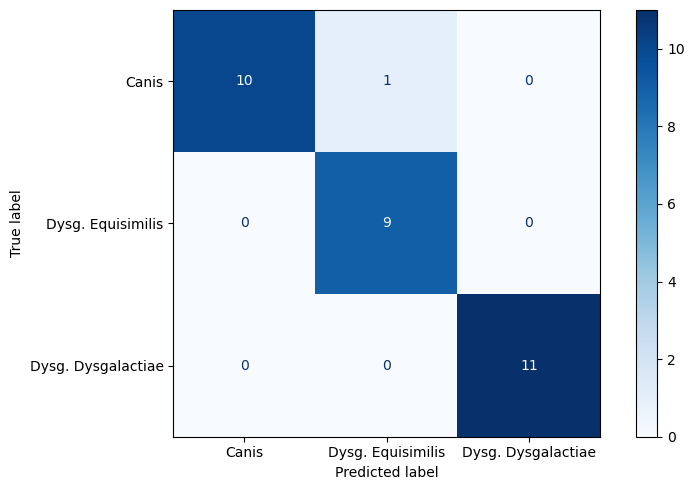

In [108]:
fig, ax = plt.subplots(figsize=(8, 5))
plot_confusion_matrix(estimator=logr10, X=X_test, y_true=y_test, cmap='Blues', display_labels=class_names, ax=ax)
plt.tight_layout()
plt.show()

In [109]:
y_pred = logr10.predict(X_test)
accuracy_logic10 = logr10.score(X_test, y_test)

report = classification_report(y_true=y_test, y_pred=y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.91      0.95        11
           1       0.90      1.00      0.95         9
           2       1.00      1.00      1.00        11

    accuracy                           0.97        31
   macro avg       0.97      0.97      0.97        31
weighted avg       0.97      0.97      0.97        31



<font color= "red">Not work</font>

#### Decision tree with 10 best corr

In [110]:
dtc10 = DecisionTreeClassifier(random_state=42)
dtc10 = dtc10.fit(X=X_train, y=y_train)
dtc10

DecisionTreeClassifier(random_state=42)

In [111]:
dtc10.get_depth()

4

In [112]:
dtc10_cv_scores = cross_val_score(estimator=dtc10, X=X_train, y=y_train, 
                                 scoring="accuracy", cv=skfold, n_jobs=N_JOBS, verbose=1)
print(f"Mean CV accuracy: {dtc10_cv_scores.mean():.4f} +/- {dtc10_cv_scores.std():.4f}")
dtc10_cv_scores

Mean CV accuracy: 0.9513 +/- 0.0398


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished


array([0.92307692, 1.        , 0.92307692, 1.        , 0.91666667,
       1.        , 1.        , 0.91666667, 0.91666667, 0.91666667])

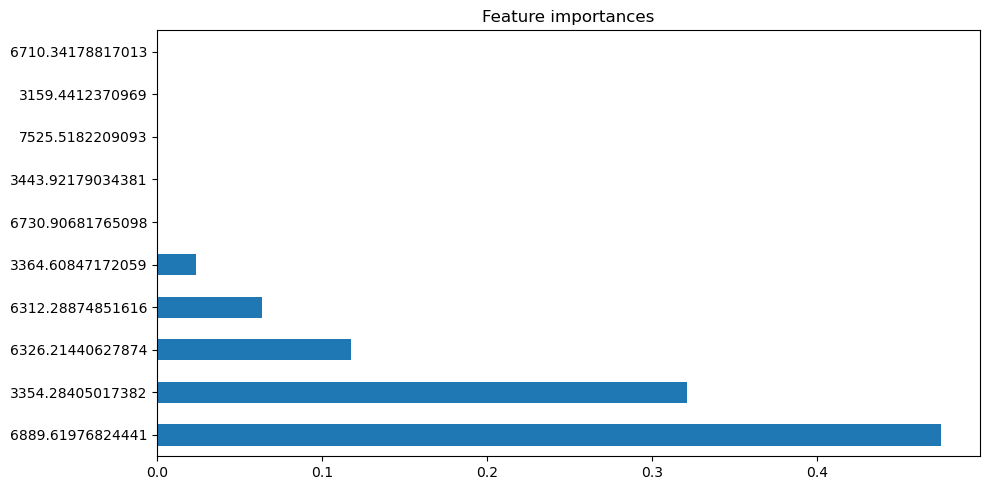

In [113]:
feature_importances = dtc10.feature_importances_
feature_index = X.columns
myDict = dict(zip(feature_index, feature_importances))
myDict = dict(sorted(myDict.items(), key=lambda item: item[1], reverse = True))

series = pd.Series(data=myDict.values(), index=myDict.keys()).head(10)
series.plot(kind="barh", figsize=(10, 5), title=f"Feature importances", legend=None)
plt.tight_layout()
plt.show()

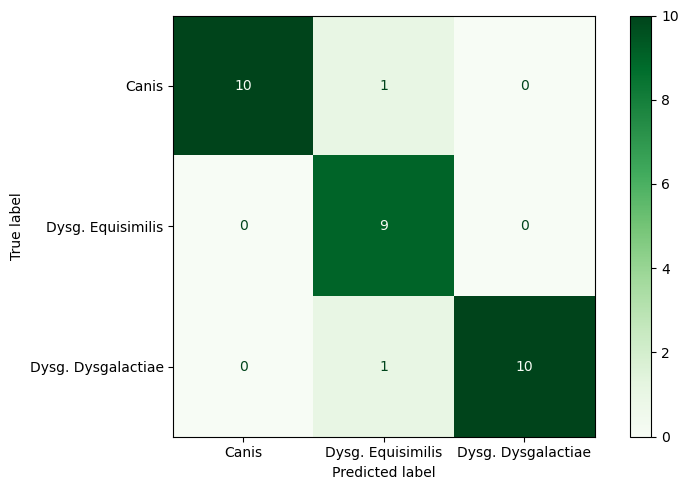

In [114]:
fig, ax = plt.subplots(figsize=(8, 5))
plot_confusion_matrix(estimator=dtc10, X=X_test, y_true=y_test, cmap='Greens', display_labels=class_names, ax=ax)
plt.tight_layout()
plt.show()

In [115]:
y_pred = dtc10.predict(X=X_test)
accuracy_tree10 = accuracy_score(y_true=y_test, y_pred=y_pred)

report = classification_report(y_true=y_test, y_pred=y_pred)
print(report)

y_pred_train = dtc10.predict(X=X_train)
accuracy_train = accuracy_score(y_true=y_train, y_pred=y_pred_train)
print(f"train accuracy score: {accuracy_train:.4f}")

              precision    recall  f1-score   support

           0       1.00      0.91      0.95        11
           1       0.82      1.00      0.90         9
           2       1.00      0.91      0.95        11

    accuracy                           0.94        31
   macro avg       0.94      0.94      0.93        31
weighted avg       0.95      0.94      0.94        31

train accuracy score: 1.0000


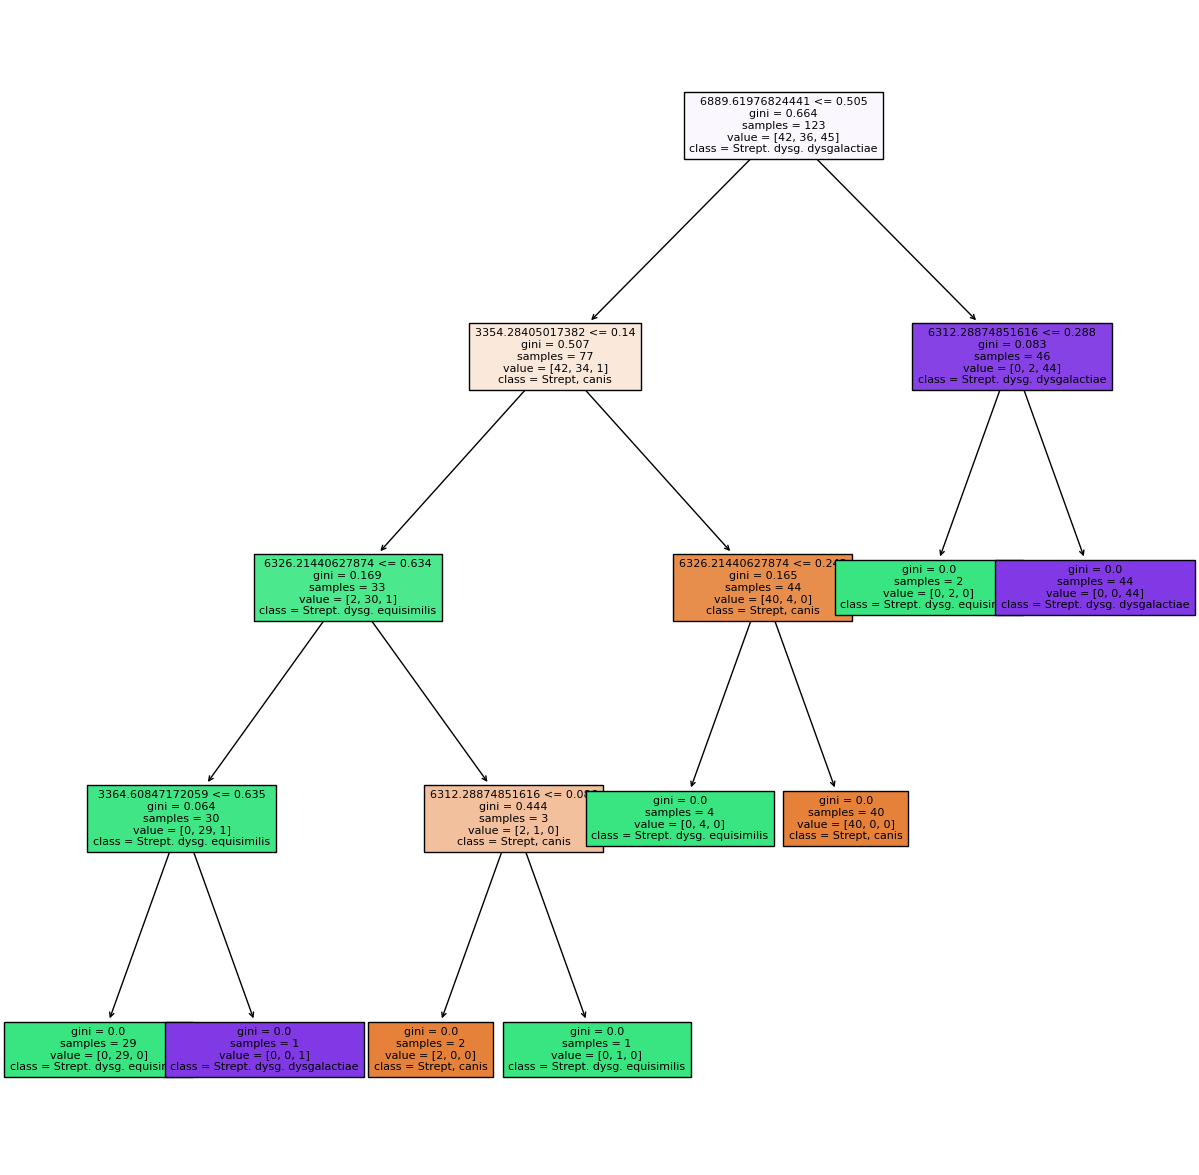

In [116]:
feature_names = feature_index
class_names = ["Strept, canis","Strept. dysg. equisimilis", "Strept. dysg. dysgalactiae"]

plt.figure(figsize=(15, 15))
plot_tree(decision_tree=dtc10, 
          feature_names=feature_names, 
          class_names=class_names, 
          filled=True, fontsize=8)
plt.show()

#### K-nn with 10 best scorr

In [117]:
knn_scores = []

for k in range(1, X_train.shape[0], 2):
    # model definition and training
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X=X_train, y=y_train)
    # compute accuracy on test set
    accuracy = knn.score(X_test, y_test)
    # store the results on a list of dictionaries
    metrics = {"# neighbors": k, "accuracy": accuracy}
    knn_scores.append(metrics)

# convert the list of dictionaries to pandas dataframe
df_knn_scores10 = pd.DataFrame(data=knn_scores)    #molto facile eveloce da dizionario a dataframe 
df_knn_scores10

,# neighbors,accuracy
0,1,0.967742
1,3,0.967742
2,5,0.967742
3,7,0.967742
4,9,0.967742
...,...,...
56,113,0.709677
57,115,0.709677
58,117,0.709677
59,119,0.709677


In [118]:
mask = df_knn_scores10["accuracy"] == df_knn_scores10["accuracy"].max()   
knn_k = df_knn_scores10["accuracy"].idxmax()
n = df_knn_scores10['# neighbors'][knn_k]
df_knn_scores10[mask]

,# neighbors,accuracy
0,1,0.967742
1,3,0.967742
2,5,0.967742
3,7,0.967742
4,9,0.967742
5,11,0.967742
17,35,0.967742
18,37,0.967742
19,39,0.967742


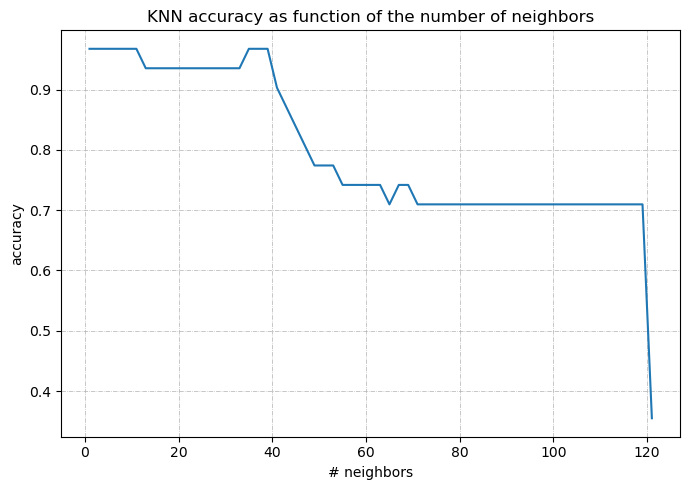

In [119]:
plt.figure(figsize=(7, 5))
plt.title("KNN accuracy as function of the number of neighbors")
sns.lineplot(x="# neighbors", y="accuracy", data=df_knn_scores10)
plt.grid(linestyle='-.', linewidth=0.5)
plt.tight_layout()
plt.show()

In [120]:
knn10 = KNeighborsClassifier(n_neighbors=n)
knn10.fit(X=X_train, y=y_train)

KNeighborsClassifier(n_neighbors=1)

In [121]:
knn10_cv_scores = cross_val_score(estimator=knn10, X=X_train, y=y_train, 
                                 scoring="accuracy", cv=skfold, n_jobs=N_JOBS, verbose=1)
print(f"Mean CV KNN accuracy: {knn10_cv_scores.mean():.4f} +/- {knn10_cv_scores.std():.4f}")
knn10_cv_scores

Mean CV KNN accuracy: 0.9756 +/- 0.0372


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished


array([1.        , 1.        , 0.92307692, 1.        , 0.91666667,
       1.        , 1.        , 1.        , 0.91666667, 1.        ])

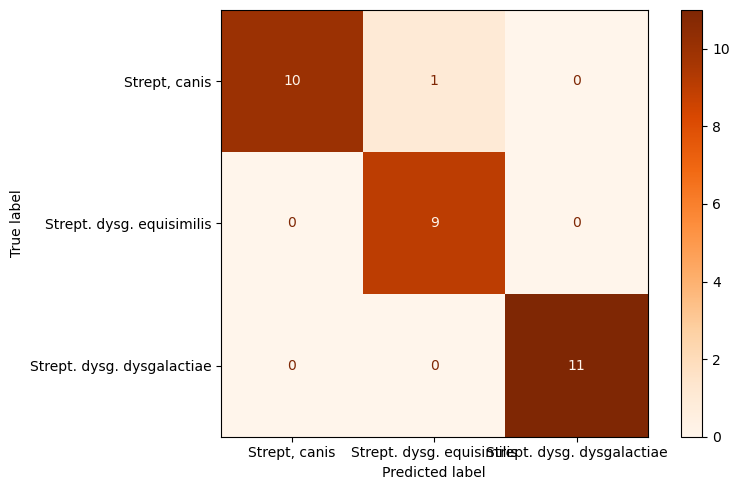

In [122]:
fig, ax = plt.subplots(figsize=(8, 5))
plot_confusion_matrix(estimator=knn10, X=X_test, y_true=y_test, cmap='Oranges', display_labels=class_names, ax=ax)
plt.tight_layout()
plt.show()

In [123]:
y_pred = knn10.predict(X=X_test)
accuracy_knn10 = accuracy_score(y_true=y_test, y_pred=y_pred)

report = classification_report(y_true=y_test, y_pred=y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.91      0.95        11
           1       0.90      1.00      0.95         9
           2       1.00      1.00      1.00        11

    accuracy                           0.97        31
   macro avg       0.97      0.97      0.97        31
weighted avg       0.97      0.97      0.97        31



<font color= "red">Not work</font>

#### Random Forest with 10 best scorr

In [124]:
rm10 = RandomForestClassifier(oob_score=True, n_jobs=N_JOBS, random_state=RANDOM_STATE)
rm10

RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=42)

In [125]:
rm_cv_scores = cross_val_score(estimator=rm10, X=X_train, y=y_train, 
                                 scoring="accuracy", cv=skfold, n_jobs=N_JOBS, verbose=1)
print(f"Mean CV Random Forest accuracy: {rm_cv_scores.mean():.4f} +/- {rm_cv_scores.std():.4f}")
rm_cv_scores

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


Mean CV Random Forest accuracy: 0.9596 +/- 0.0404


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.9s finished


array([0.92307692, 1.        , 0.92307692, 1.        , 0.91666667,
       1.        , 1.        , 0.91666667, 0.91666667, 1.        ])

In [126]:
n_estimator = 250
max_features = 'sqrt'
max_depth = 20
criterion = 'entropy'
class_weight = 'balanced_subsample'

best_rm10 = RandomForestClassifier(n_estimators=n_estimator, max_features=max_features, max_depth=max_depth, class_weight=class_weight, criterion=criterion, oob_score=True, n_jobs=N_JOBS, random_state=RANDOM_STATE)
best_rm10.fit(X=X_train, y=y_train)

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=20, n_estimators=250, n_jobs=-1,
                       oob_score=True, random_state=42)

In [127]:
best10_rm_cv_scores = cross_val_score(estimator=best_rm10, X=X_train, y=y_train, 
                                 scoring="accuracy", cv=skfold, n_jobs=N_JOBS, verbose=1)
print(f"Mean CV Best Random Forest accuracy: {best10_rm_cv_scores.mean():.4f} +/- {best10_rm_cv_scores.std():.4f}")
best10_rm_cv_scores

[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


Mean CV Best Random Forest accuracy: 0.9596 +/- 0.0404


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   11.6s finished


array([0.92307692, 1.        , 0.92307692, 1.        , 0.91666667,
       1.        , 1.        , 0.91666667, 0.91666667, 1.        ])

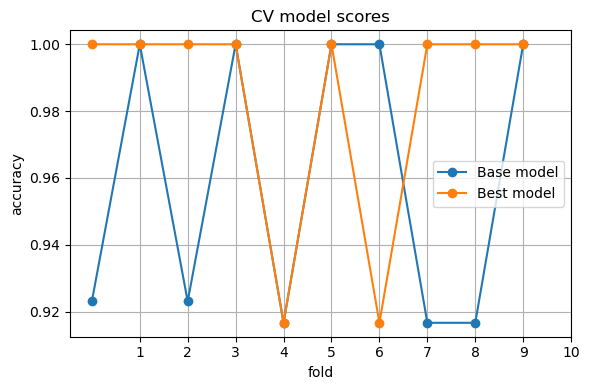

In [128]:
plt.figure(figsize=(6, 4))
plt.title("CV model scores")
plt.plot(rm_cv_scores, marker="o")
plt.plot(best_rm_cv_scores, marker="o")
plt.xticks(ticks=range(1, 11))
plt.xlabel("fold")
plt.ylabel("accuracy")
plt.legend(["Base model", "Best model"])
plt.tight_layout()
plt.grid()
plt.show()

<font color= "red">Come mostro solo le prime 10?</font>

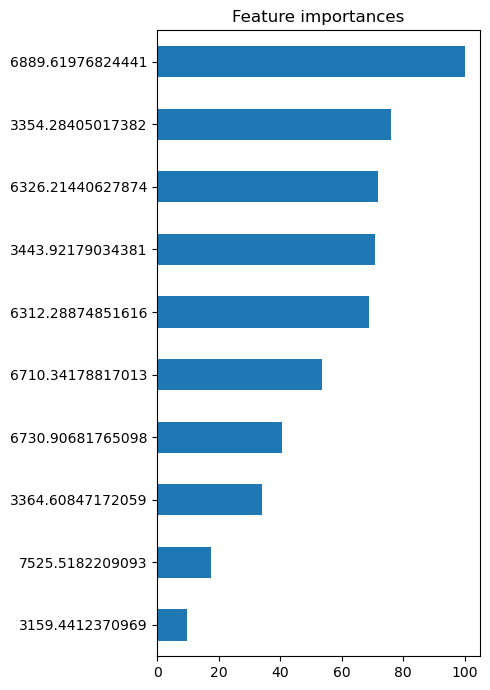

In [129]:
feature_importances_plot(model=best_rm10, labels=X.columns)

In [130]:
best_rm10.oob_score_

0.959349593495935

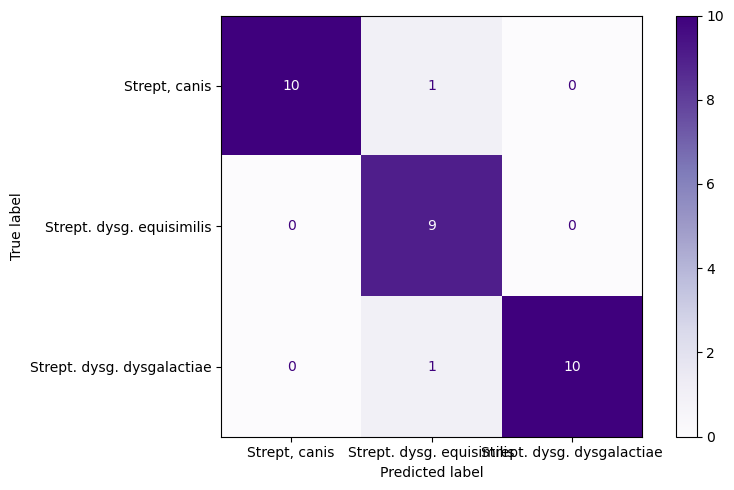

In [131]:
fig, ax = plt.subplots(figsize=(8, 5))
plot_confusion_matrix(estimator=best_rm10, X=X_test, y_true=y_test, cmap='Purples', display_labels=class_names, ax=ax)
plt.tight_layout()
plt.show()

In [132]:
y_pred = best_rm10.predict(X_test)
accuracy_rm10 = accuracy_score(y_true=y_test, y_pred=y_pred)

report = classification_report(y_true=y_test, y_pred=y_pred)
print(report)

r2_rf = r2_score(y_test, y_pred)
print('R2 score of random forest classifier with PCA on test set: {:.3f}'.format(r2_rf))

rmse_rf = mean_squared_error(y_test, y_pred, squared=False)
print('R2 score of random forest classifier with PCA on test set: {:.3f}'.format(rmse_rf))

              precision    recall  f1-score   support

           0       1.00      0.91      0.95        11
           1       0.82      1.00      0.90         9
           2       1.00      0.91      0.95        11

    accuracy                           0.94        31
   macro avg       0.94      0.94      0.93        31
weighted avg       0.95      0.94      0.94        31

R2 score of random forest classifier with PCA on test set: 0.909
R2 score of random forest classifier with PCA on test set: 0.254


In [133]:
data_accuracy = [['Maldi (46 feat)',accuracy_logic,accuracy_tree,accuracy_knn,accuracy_rm],
                 ['Maldi with PCA',accuracy_logic_pca,accuracy_tree_pca,accuracy_knn_pca,accuracy_rm_pca],
                 ['Maldi with PCA2',accuracy_logic_pca2,accuracy_tree_pca2,accuracy_knn_pca2,accuracy_rm_pca2],
                 ['Maldi with 10 features',accuracy_logic10,accuracy_tree10,accuracy_knn10,accuracy_rm10]]
feature_index = ['Feature','Logistic Regression', 'Decision Tree', 'Knn', 'Random Forest']

df_accuracy = pd.DataFrame(data_accuracy, columns=feature_index)
df_accuracy.to_csv('accuracy_maldi_46picchi_pca_95_MM.csv', index=False)
df_accuracy

,Feature,Logistic Regression,Decision Tree,Knn,Random Forest
0,Maldi (46 feat),0.935484,0.935484,0.935484,0.935484
1,Maldi with PCA,0.967742,0.935484,0.967742,0.967742
2,Maldi with PCA2,0.967742,1.000000,1.000000,0.967742
3,Maldi with 10 features,0.967742,0.935484,0.967742,0.935484


In [134]:
data_cv = [['Maldi (46 feat)',logr_cv_scores.mean(),dtc_cv_scores.mean(),knn_cv_scores.mean(),best_rm_cv_scores.mean()],
    ['Maldi with PCA',logr_pca_cv_scores.mean(),dtc_pca_cv_scores.mean(),knn_pca_cv_scores.mean(),best_pca_rm_cv_scores.mean()],
    ['Maldi with PCA2',logr_pca2_cv_scores.mean(),dtc_pca2_cv_scores.mean(),knn_pca2_cv_scores.mean(),best_pca2_rm_cv_scores.mean()],
    ['Maldi with 10 features',logr10_cv_scores.mean(),dtc10_cv_scores.mean(),knn10_cv_scores.mean(),best10_rm_cv_scores.mean()]]
feature_index = ['Feature','Logistic Regression CV', 'Decision Tree CV', 'Knn CV', 'Random Forest CV']




df_cv = pd.DataFrame(data_cv, columns=feature_index)
df_cv.to_csv('cross_validation_maldi_46picchi_pca_95_MM.csv', index=False)
df_cv

,Feature,Logistic Regression CV,Decision Tree CV,Knn CV,Random Forest CV
0,Maldi (46 feat),0.951923,0.935256,0.950641,0.983333
1,Maldi with PCA,0.960256,0.917949,0.950641,0.951282
2,Maldi with PCA2,0.902564,0.876923,0.893590,0.884615
3,Maldi with 10 features,0.959615,0.951282,0.975641,0.959615
